# This notebook is for the purpose of model development

## Let's check to see that we can access CUDA GPU acceleration.

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 3080 Ti


## All good there. Let's now load our dataset.

In [2]:
# we need our custom class defined for pickle
class SyntheticEventDataset(torch.utils.data.Dataset):
    def __init__(self, csv_folder_path):
        pass
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class CustomDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        data, target = self.original_dataset[idx]
        
        # Unsqueeze the feature tensor to add the last dimension
        data = data.unsqueeze(-1)  # Add dimension at the end to make it (27500, 1)
        
        # Extract only the first value from the target tensor (if necessary)
        target = target
        
        return data, target

test_dataset_cm = torch.load('PyTorch_Synthetic_Data/synthetic_signal_dataset.pt', weights_only=False)
wrapped_test_dataset_cm = CustomDatasetWrapper(test_dataset_cm)

## With the dataset read in, let's define some DataLoaders.

In [3]:
from torch.utils.data import DataLoader

batch_size = 32

test_loader = DataLoader(wrapped_test_dataset_cm, batch_size=batch_size, shuffle=False)


# Here we can see that our data is loading correctly
X, y = next(iter(test_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 27500, 1])
Target shape: torch.Size([32])


## Excellent, with the data handling steps in place we can move on to building the neural net.

In [4]:
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_units, dense_sizes, dropout_prob):
        super(CustomModel, self).__init__()
        
        # Initial convolutional layer with 8 out_channels, kernel size 64, linear activation
        self.conv1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=8,
            kernel_size=64,
            stride=1,
            padding=32  # To keep the output size the same (valid padding)
        )
        self.conv1_activation = nn.Identity()  # Linear activation, no change
        
        # Convolutional layers with 8 out_channels, kernel size 32, ReLU activation
        self.conv2 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16  # To keep output size the same
        )
        self.conv2_activation = nn.ReLU()
        
        self.conv3 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16  # To keep output size the same
        )
        self.conv3_activation = nn.ReLU()
        
        # Flatten, Batch Normalization and Max Pooling layers
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(8)
        self.max_pool = nn.MaxPool1d(kernel_size=3)
        
        # Repeating the 2 convolution + batch normalization + max pooling sequence
        self.conv4 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16
        )
        self.conv4_activation = nn.ReLU()
        
        self.conv5 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16
        )
        self.conv5_activation = nn.ReLU()
        
        # Second sequence of Batch Normalization and Max Pooling
        self.batch_norm2 = nn.BatchNorm1d(8)
        
        # Final convolution layer with 16 out_channels, kernel size 16, linear activation
        self.conv6 = nn.Conv1d(
            in_channels=8,
            out_channels=16,
            kernel_size=16,
            stride=2,
            padding=8  # To keep output size the same
        )
        self.conv6_activation = nn.Identity()  # Linear activation, no change
        
        # Max Pooling after the last convolution
        self.max_pool2 = nn.MaxPool1d(kernel_size=3)
        
        # Bi-directional LSTM layer with 8 hidden units
        self.lstm = nn.LSTM(
            input_size=16,  # The output of the last conv layer (16 channels)
            hidden_size=lstm_hidden_units,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        # Flatten after LSTM and fully connected layers with decreasing size
        self.fc1 = nn.Linear(lstm_hidden_units * 2, dense_sizes[0])  # *2 for bidirectional
        self.fc2 = nn.Linear(dense_sizes[0], dense_sizes[1])
        self.fc3 = nn.Linear(dense_sizes[1], dense_sizes[2])
        self.fc4 = nn.Linear(dense_sizes[2], dense_sizes[3])
        self.output = nn.Linear(dense_sizes[3], 1)  # Output single feature
        
        # ReLU activations for dense layers (except the last one)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Ensure the input shape is [batch_size, in_channels, seq_length]
        x = x.transpose(1, 2)  # [batch_size, 1, seq_length]
        
        # Initial convolution and activation
        x = self.conv1(x)
        x = self.conv1_activation(x)  # Linear, no activation change
        
        # First set of convolutions with ReLU activations
        x = self.conv2(x)
        x = self.conv2_activation(x)
        x = self.conv3(x)
        x = self.conv3_activation(x)
        
        # Batch normalization and max pooling
        x = self.max_pool(x)
        x = self.batch_norm(x)
        
        # Second set of convolutions with ReLU activations
        x = self.conv4(x)
        x = self.conv4_activation(x)
        x = self.conv5(x)
        x = self.conv5_activation(x)
        
        # Batch normalization and max pooling
        x = self.max_pool(x)
        x = self.batch_norm2(x)
        
        # Final convolution with linear activation and max pooling
        x = self.conv6(x)
        x = self.conv6_activation(x)  # Linear, no activation change
        x = self.max_pool2(x)
        
        # Prepare data for LSTM: reshape to [batch_size, seq_len, input_size]
        x = x.transpose(1, 2)  # LSTM expects [batch_size, seq_len, input_size]
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Get the last hidden state (forward and backward for bidirectional)
        last_hidden_state = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Shape: (batch_size, hidden_size * 2)
        
        # Dense layers with ReLU activations and dropout
        x = self.relu(self.fc1(last_hidden_state))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation after the last dense layer
        
        # Output layer: final single value prediction
        output = self.output(x)  # Shape: (batch_size, 1)
        output = output.squeeze(1)
        return output

# Example initialization
model = CustomModel(
    input_size=1,                # Feature size (e.g., raw strain data per timestep) 
    lstm_hidden_units=8,         # LSTM hidden units
    dense_sizes=[64, 32, 16, 8], # Sizes of the tapering dense layers
    dropout_prob=0.05             # Dropout probability
)

print(model)
print(f"Num of params:{sum(p.numel() for p in model.parameters())}")

CustomModel(
  (conv1): Conv1d(1, 8, kernel_size=(64,), stride=(1,), padding=(32,))
  (conv1_activation): Identity()
  (conv2): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv2_activation): ReLU()
  (conv3): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv3_activation): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv4_activation): ReLU()
  (conv5): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv5_activation): ReLU()
  (batch_norm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(8, 16, kernel_size=(16,), stride=(2,), padding=(8,))
  (conv6_activation): Identity()
  (max_pool2): MaxPool1d(kernel_size=3, stride=3, pad

## Define the hyper parameters for our model

In [115]:
learning_rate = 1e-5

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Define the training and validation loop

In [116]:
import time
from tqdm import tqdm

def train_model(data_loader, model, loss_function, optimizer, device="cuda"):
    """
    Train the model for one epoch.

    Args:
        data_loader (DataLoader): DataLoader for the training data.
        model (nn.Module): The PyTorch model to train.
        loss_function (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (str): Device to use ('cpu' or 'cuda').
    """
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for X, y in progress_bar:
        # Move data and target to the specified device
        X, y = X.to(device), y.to(device)

        # Forward pass
        output = model(X)
        loss = loss_function(output, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / num_batches
    #print(f"Train loss: {avg_loss:.4f}")
    return avg_loss

def validate_model(data_loader, model, loss_function, device="cuda"):
    """
    Evaluate the model on the test/validation data.

    Args:
        data_loader (DataLoader): DataLoader for the test/validation data.
        model (nn.Module): The PyTorch model to evaluate.
        loss_function (nn.Module): The loss function.
        device (str): Device to use ('cpu' or 'cuda').
    """
    model.eval()
    total_loss = 0
    num_batches = len(data_loader)

    progress_bar = tqdm(data_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for X, y in progress_bar:
            # Move data and target to the specified device
            X, y = X.to(device), y.to(device)

            # Forward pass
            output = model(X)
            loss = loss_function(output, y)

            # Track loss
            total_loss += loss.item()

            # Update progress bar with the current loss
            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / num_batches
    #print(f"Validation loss: {avg_loss:.4f}")
    return avg_loss

Epoch 0
---------


Train Loss: 2041.7657 -|- Validation Loss: 1980.9364 -|- Epoch Time: 38.9613 seconds


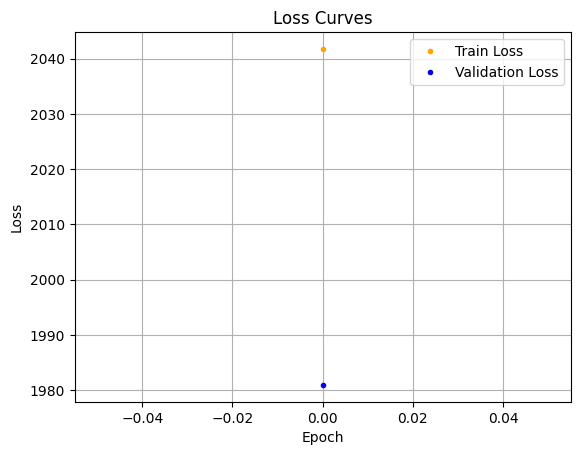


Epoch 1
---------


Train Loss: 1816.0115 -|- Validation Loss: 1572.3053 -|- Epoch Time: 38.6245 seconds


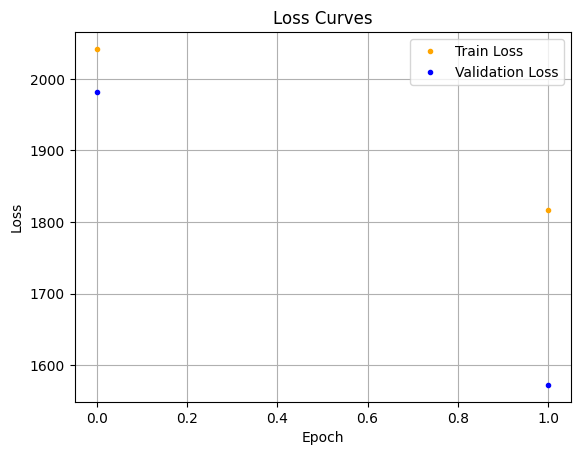


Epoch 2
---------


Train Loss: 1168.5239 -|- Validation Loss: 716.4904 -|- Epoch Time: 38.6627 seconds


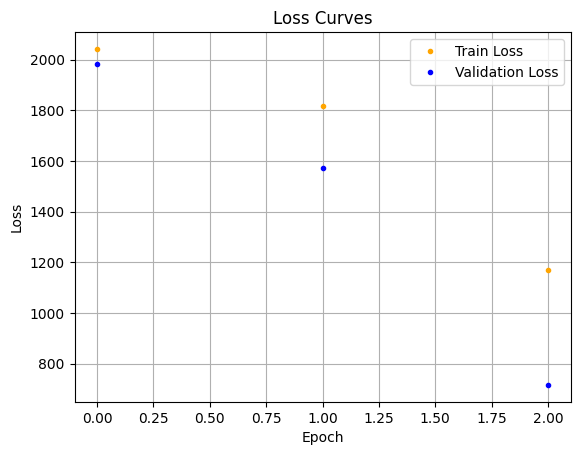


Epoch 3
---------


Train Loss: 422.1775 -|- Validation Loss: 192.3870 -|- Epoch Time: 38.6118 seconds


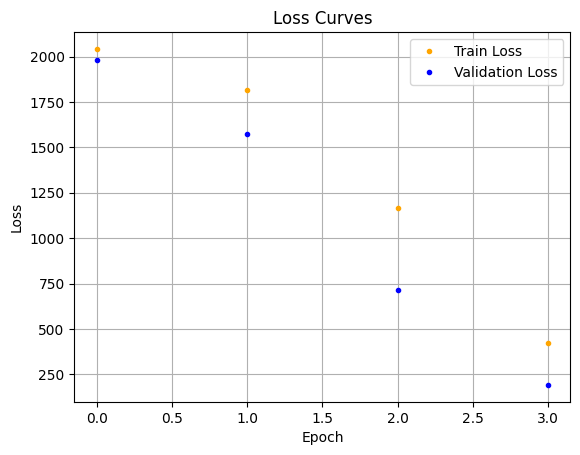


Epoch 4
---------


Train Loss: 108.3028 -|- Validation Loss: 63.4610 -|- Epoch Time: 38.7212 seconds


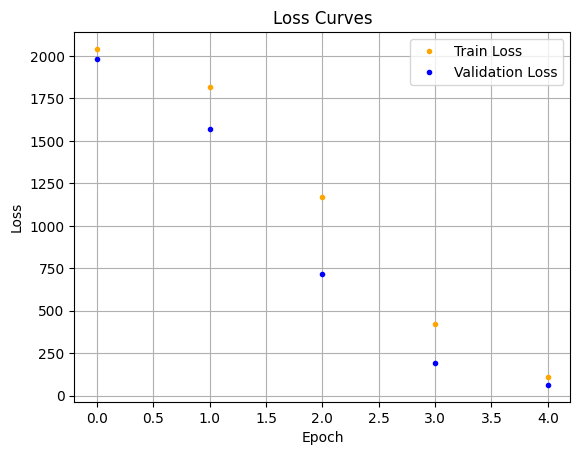


Epoch 5
---------


Train Loss: 49.0037 -|- Validation Loss: 38.3985 -|- Epoch Time: 38.7420 seconds


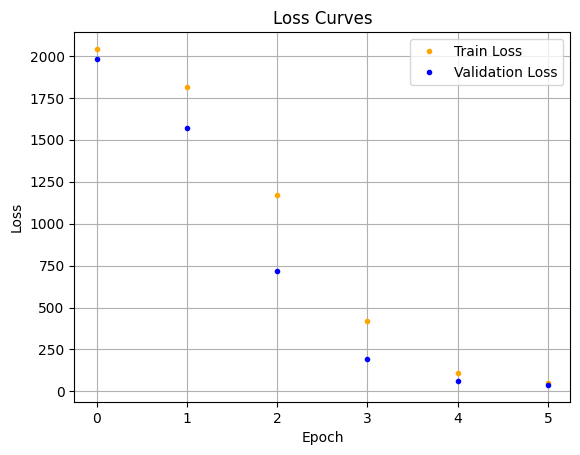


Epoch 6
---------


Train Loss: 34.7764 -|- Validation Loss: 31.7544 -|- Epoch Time: 38.7598 seconds


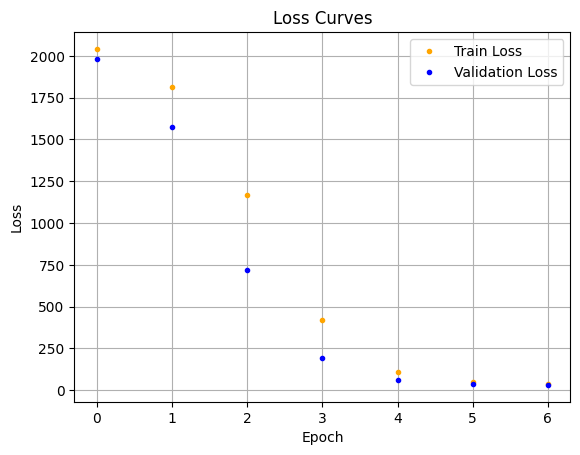


Epoch 7
---------


Train Loss: 29.8988 -|- Validation Loss: 28.8014 -|- Epoch Time: 38.7379 seconds


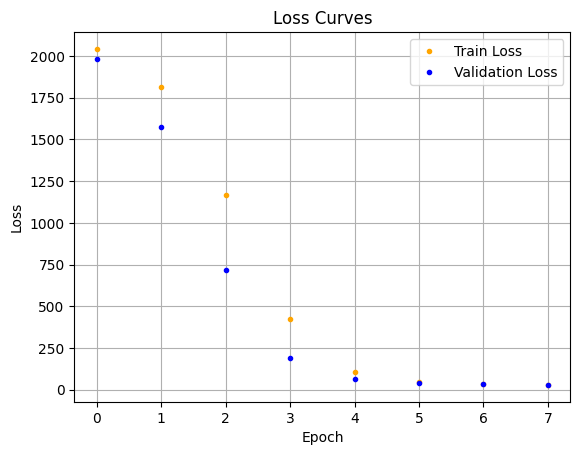


Epoch 8
---------


Train Loss: 27.6148 -|- Validation Loss: 26.7897 -|- Epoch Time: 38.7531 seconds


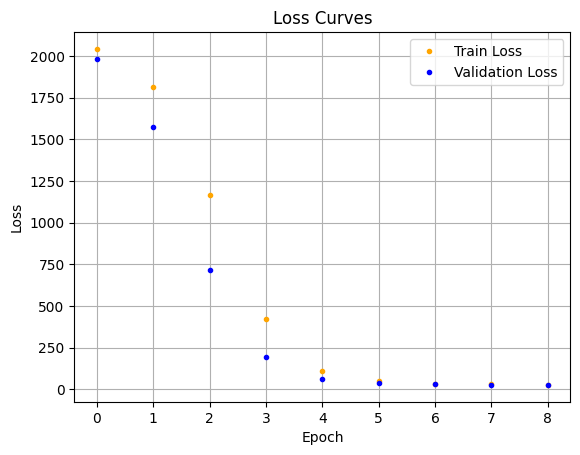


Epoch 9
---------


Train Loss: 26.0070 -|- Validation Loss: 25.6109 -|- Epoch Time: 38.7565 seconds


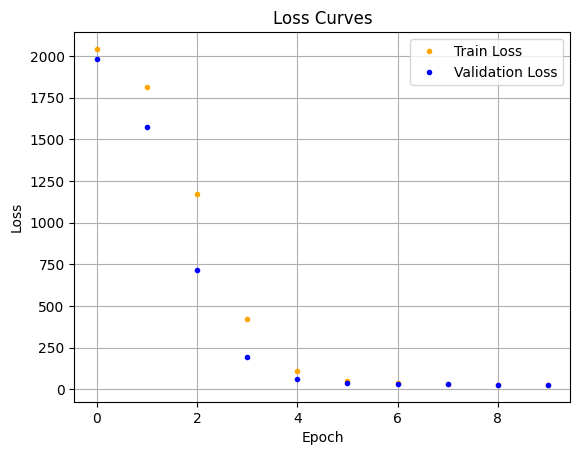


Epoch 10
---------


Train Loss: 24.9479 -|- Validation Loss: 24.9465 -|- Epoch Time: 38.7850 seconds


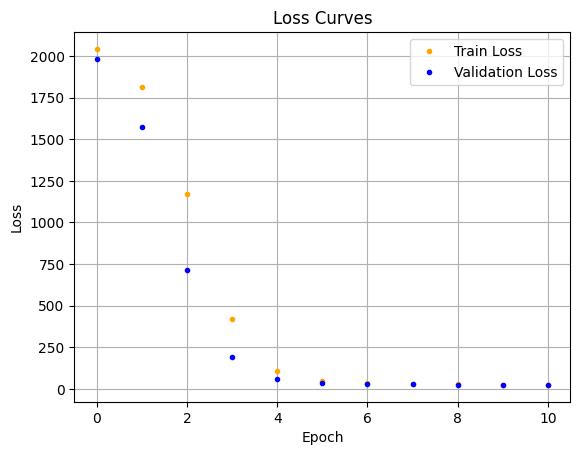


Epoch 11
---------


Train Loss: 24.0905 -|- Validation Loss: 25.0151 -|- Epoch Time: 38.7894 seconds


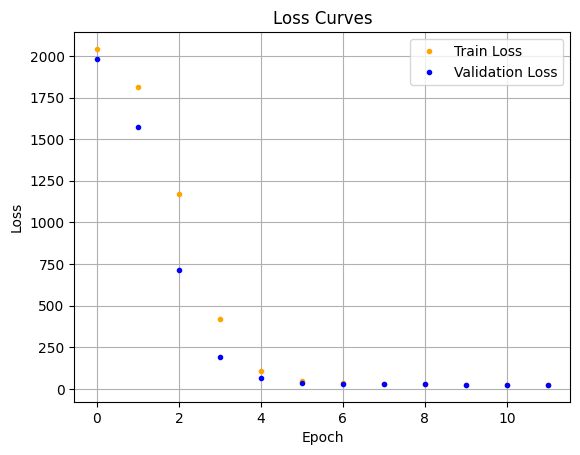


Epoch 12
---------


Train Loss: 23.4648 -|- Validation Loss: 24.0094 -|- Epoch Time: 38.7179 seconds


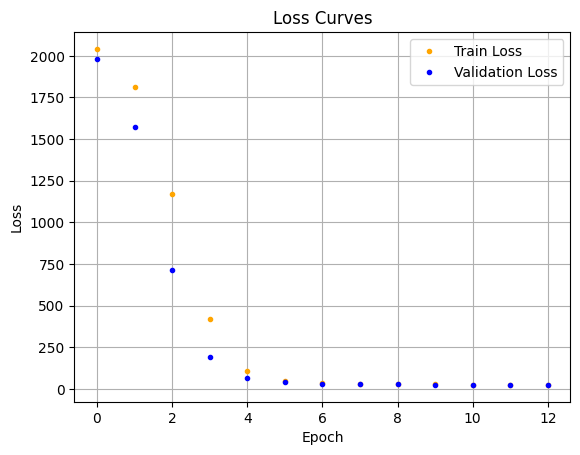


Epoch 13
---------


Train Loss: 22.9177 -|- Validation Loss: 23.4453 -|- Epoch Time: 38.7251 seconds


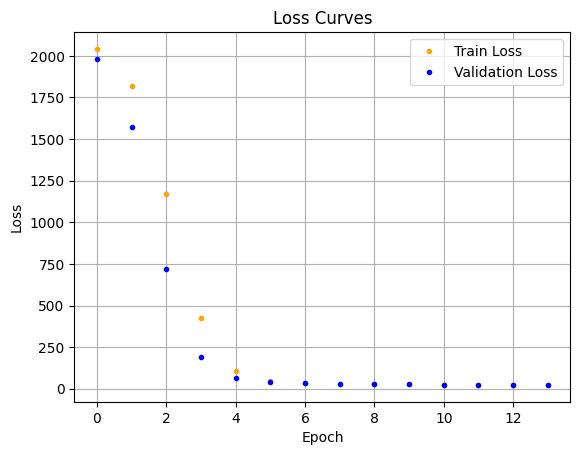


Epoch 14
---------


Train Loss: 22.4498 -|- Validation Loss: 23.1469 -|- Epoch Time: 38.7527 seconds


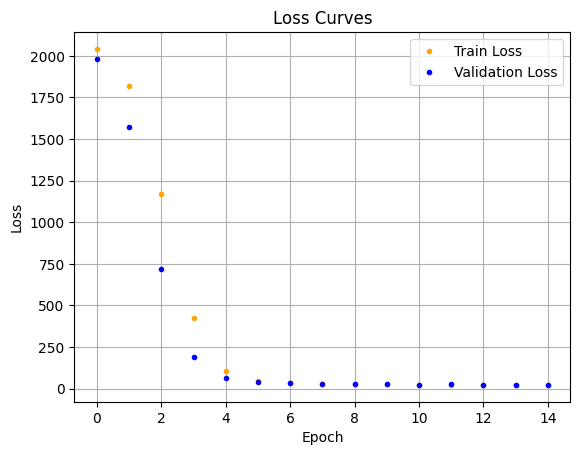


Epoch 15
---------


Train Loss: 22.0709 -|- Validation Loss: 22.7595 -|- Epoch Time: 38.6985 seconds


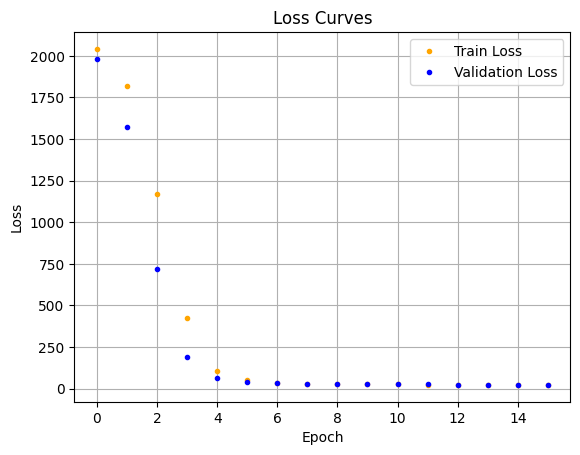


Epoch 16
---------


Train Loss: 21.7492 -|- Validation Loss: 22.5122 -|- Epoch Time: 38.8018 seconds


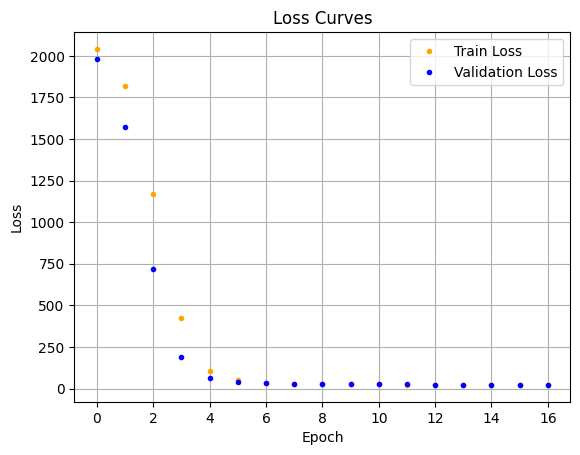


Epoch 17
---------


Train Loss: 21.3899 -|- Validation Loss: 22.4577 -|- Epoch Time: 38.7861 seconds


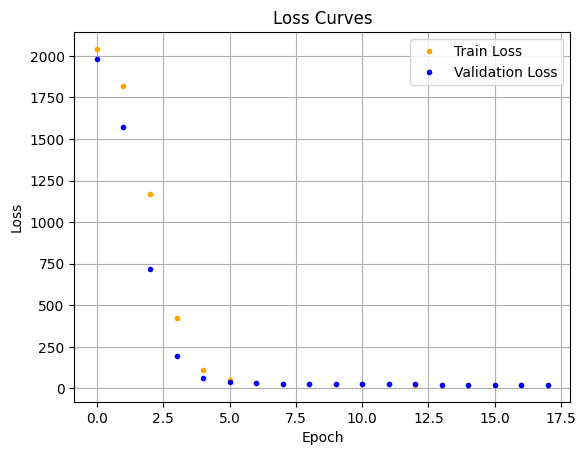


Epoch 18
---------


Train Loss: 21.1164 -|- Validation Loss: 22.0678 -|- Epoch Time: 38.6892 seconds


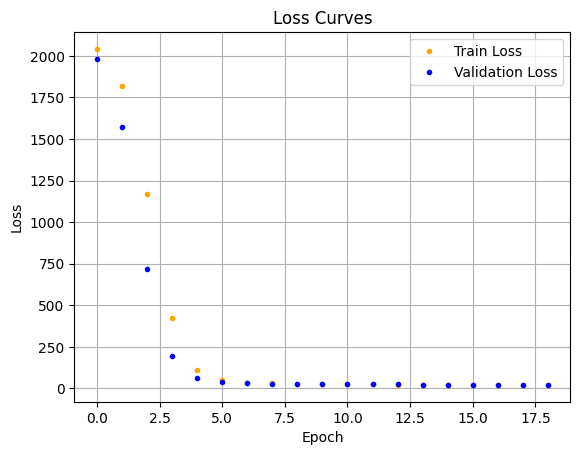


Epoch 19
---------


Train Loss: 20.8597 -|- Validation Loss: 21.9116 -|- Epoch Time: 38.6489 seconds


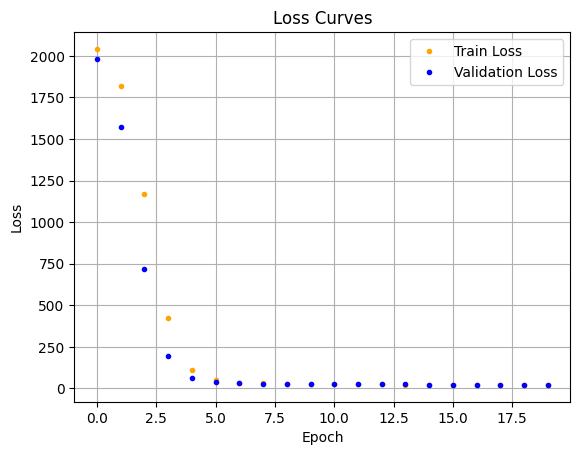


Epoch 20
---------


Train Loss: 20.6223 -|- Validation Loss: 21.6308 -|- Epoch Time: 38.6284 seconds


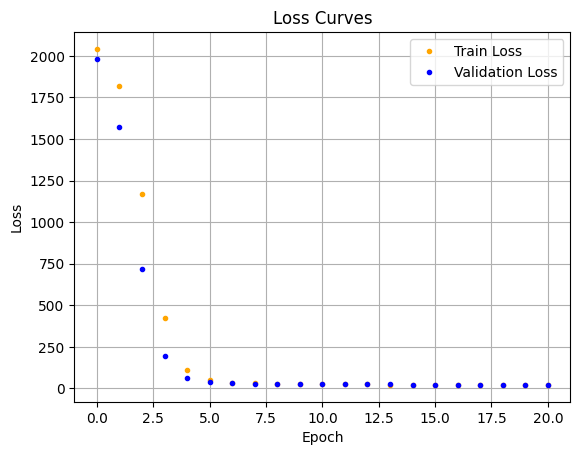


Epoch 21
---------


Train Loss: 20.4371 -|- Validation Loss: 21.4452 -|- Epoch Time: 38.6676 seconds


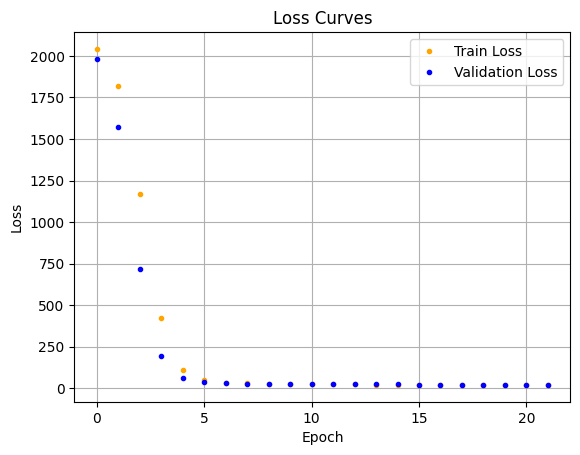


Epoch 22
---------


Train Loss: 20.2085 -|- Validation Loss: 21.5668 -|- Epoch Time: 38.6580 seconds


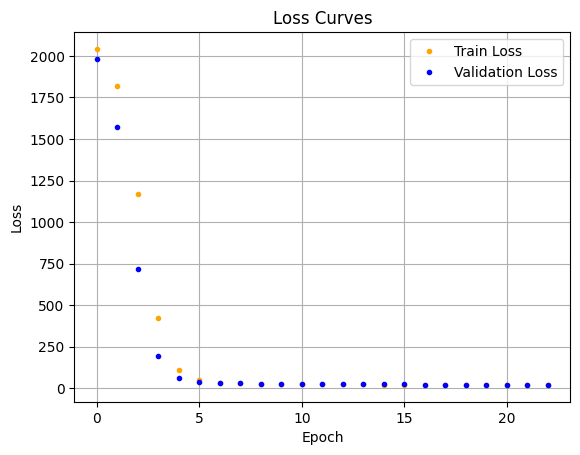


Epoch 23
---------


Train Loss: 20.0400 -|- Validation Loss: 21.2939 -|- Epoch Time: 38.6555 seconds


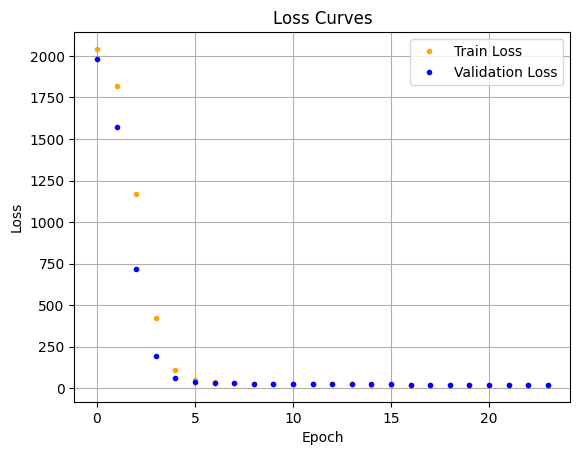


Epoch 24
---------


Train Loss: 19.8312 -|- Validation Loss: 20.9338 -|- Epoch Time: 38.6725 seconds


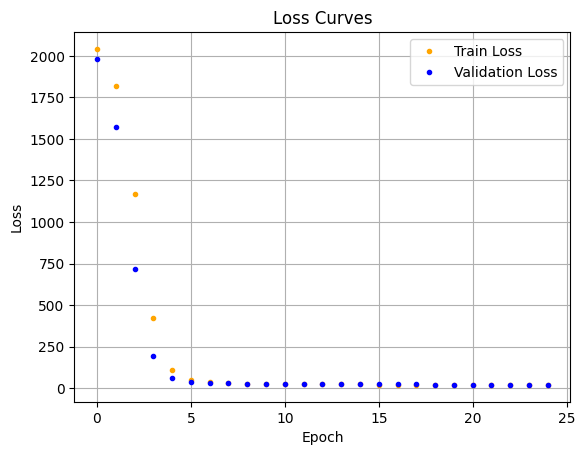


Epoch 25
---------


Train Loss: 19.7186 -|- Validation Loss: 20.8429 -|- Epoch Time: 38.6657 seconds


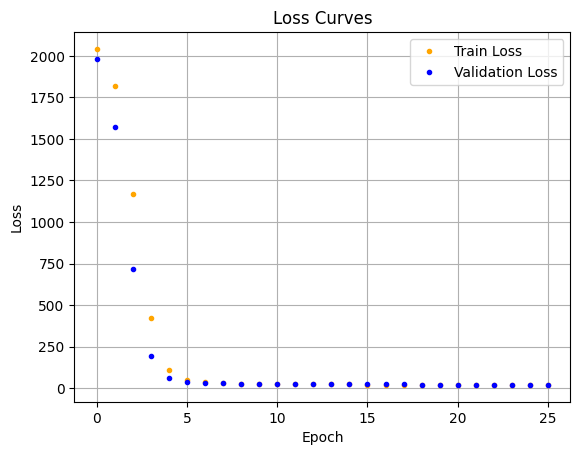


Epoch 26
---------


Train Loss: 19.5613 -|- Validation Loss: 20.8082 -|- Epoch Time: 38.6883 seconds


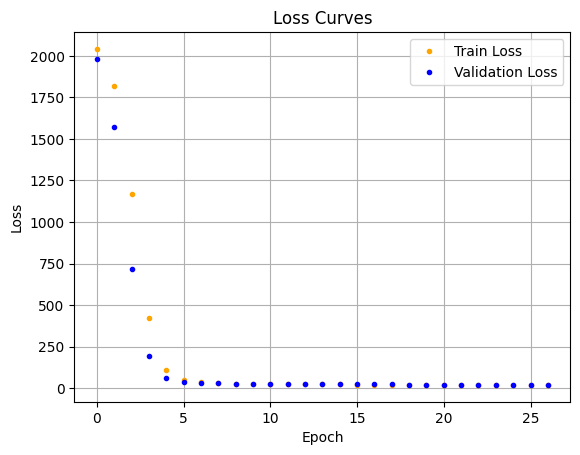


Epoch 27
---------


Train Loss: 19.3969 -|- Validation Loss: 20.8244 -|- Epoch Time: 38.6860 seconds


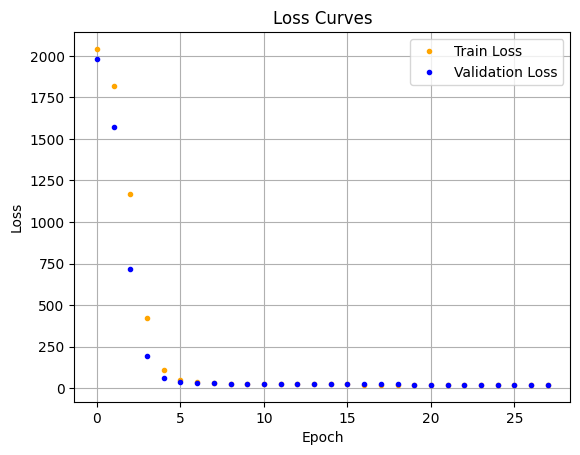


Epoch 28
---------


Train Loss: 19.1882 -|- Validation Loss: 20.9388 -|- Epoch Time: 38.6991 seconds


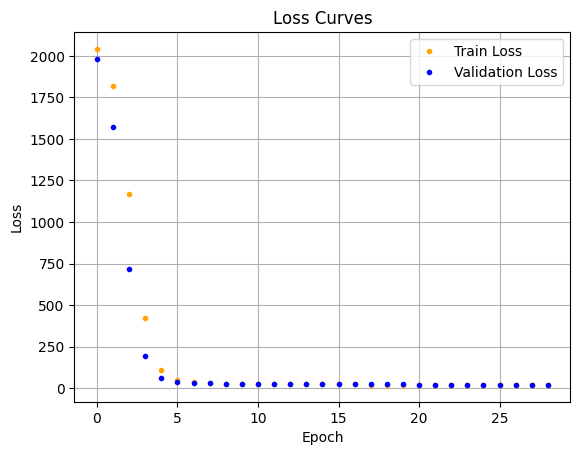


Epoch 29
---------


Train Loss: 19.0552 -|- Validation Loss: 20.4239 -|- Epoch Time: 38.6948 seconds


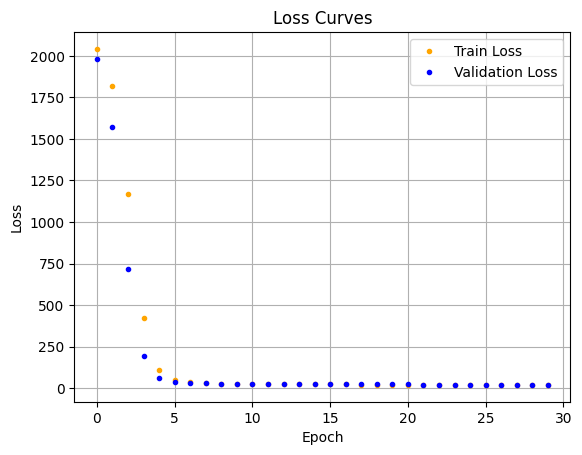


Epoch 30
---------


Train Loss: 18.9681 -|- Validation Loss: 20.3535 -|- Epoch Time: 38.6931 seconds


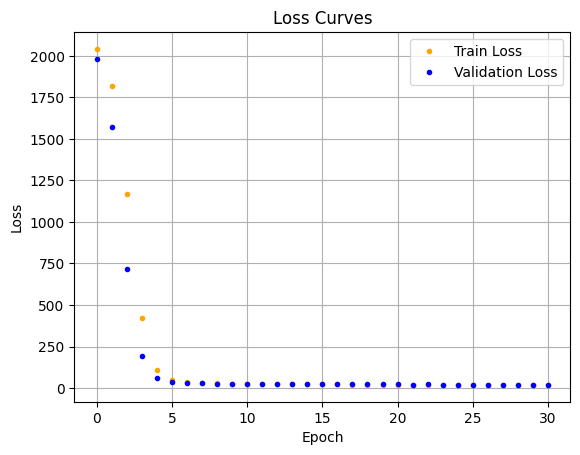


Epoch 31
---------


Train Loss: 18.8070 -|- Validation Loss: 20.2849 -|- Epoch Time: 38.6058 seconds


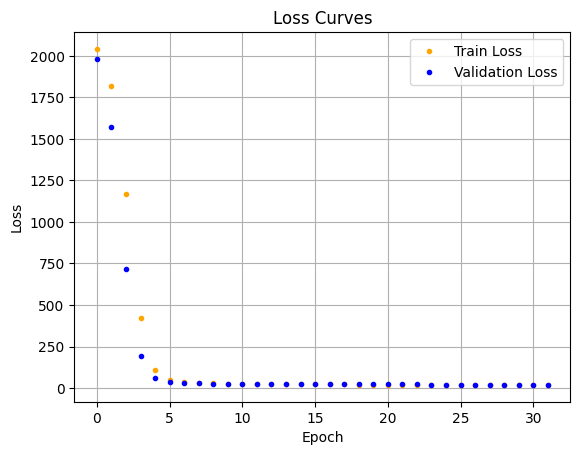


Epoch 32
---------


Train Loss: 18.6394 -|- Validation Loss: 20.3429 -|- Epoch Time: 38.6191 seconds


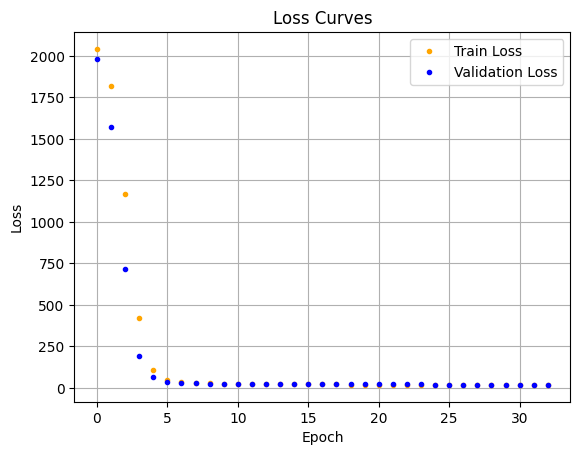


Epoch 33
---------


Train Loss: 18.4759 -|- Validation Loss: 20.3767 -|- Epoch Time: 38.6472 seconds


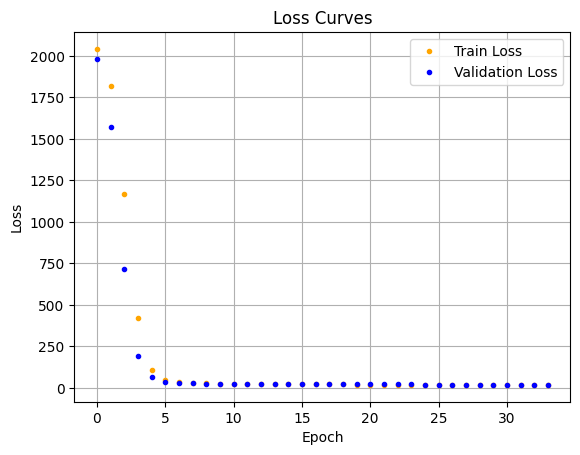


Epoch 34
---------


Train Loss: 18.4309 -|- Validation Loss: 20.5282 -|- Epoch Time: 38.6098 seconds


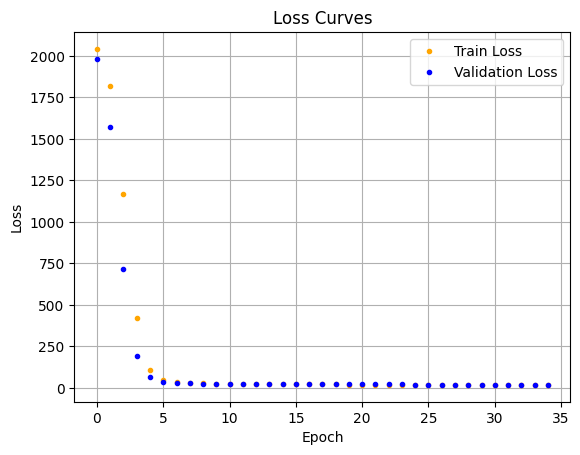


Epoch 35
---------


Train Loss: 18.2765 -|- Validation Loss: 20.1674 -|- Epoch Time: 38.6401 seconds


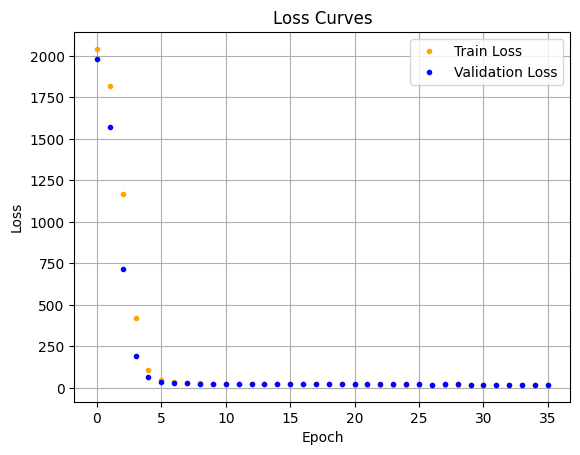


Epoch 36
---------


Train Loss: 18.1661 -|- Validation Loss: 19.9851 -|- Epoch Time: 38.8118 seconds


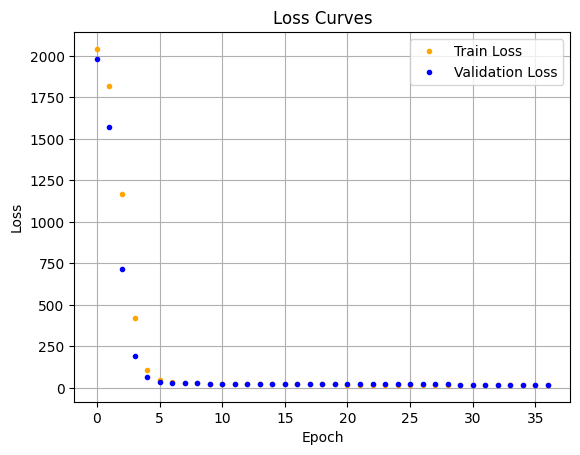


Epoch 37
---------


Train Loss: 18.0855 -|- Validation Loss: 19.8645 -|- Epoch Time: 38.7661 seconds


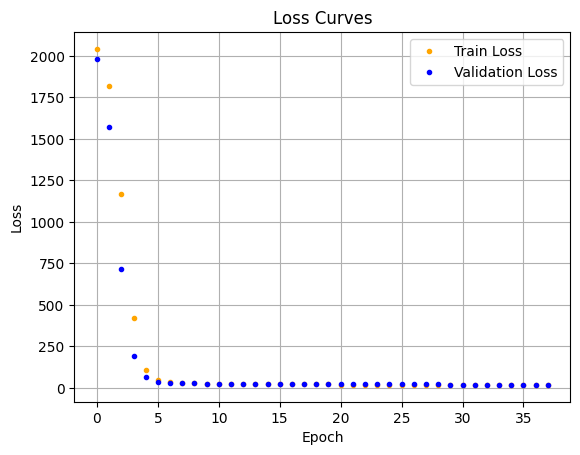


Epoch 38
---------


Train Loss: 17.9110 -|- Validation Loss: 19.9118 -|- Epoch Time: 38.8128 seconds


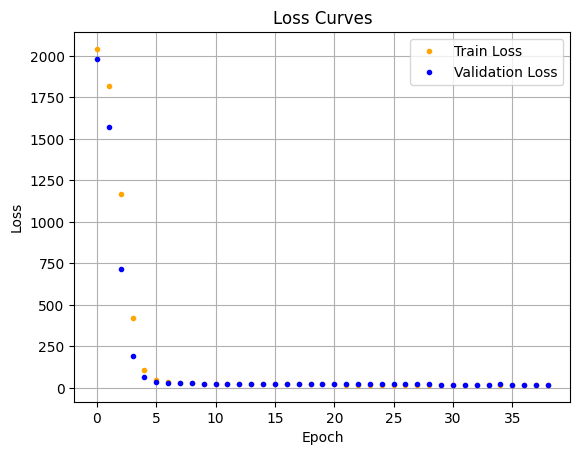


Epoch 39
---------


Train Loss: 17.8427 -|- Validation Loss: 19.7654 -|- Epoch Time: 38.8115 seconds


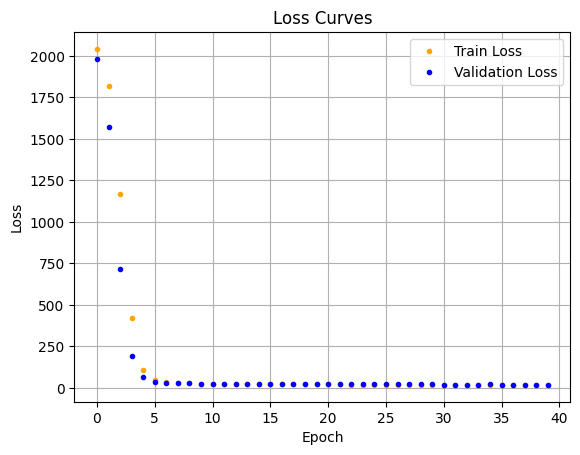


Epoch 40
---------


Train Loss: 17.7239 -|- Validation Loss: 19.8492 -|- Epoch Time: 38.7686 seconds


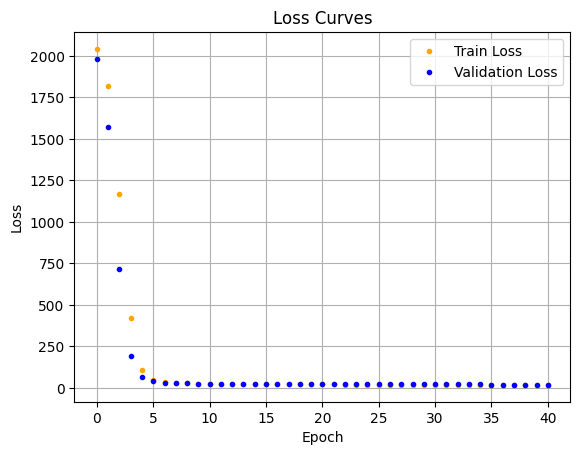


Epoch 41
---------


Train Loss: 17.6175 -|- Validation Loss: 19.7210 -|- Epoch Time: 38.8251 seconds


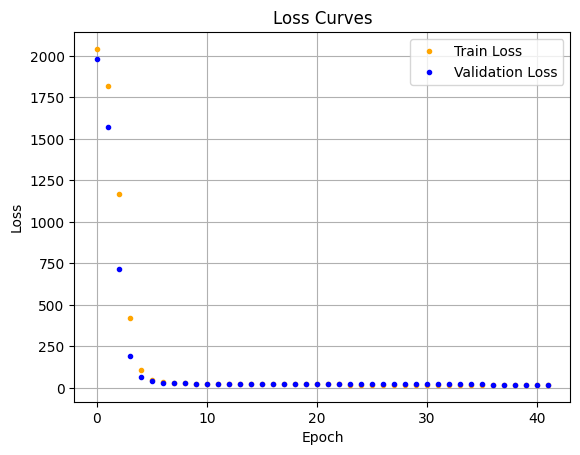


Epoch 42
---------


Train Loss: 17.4844 -|- Validation Loss: 19.5728 -|- Epoch Time: 38.7730 seconds


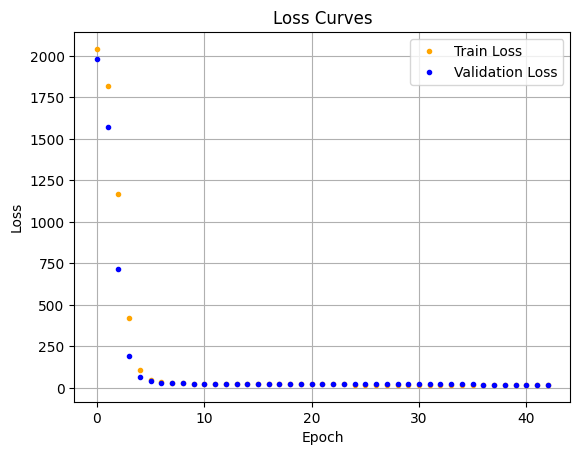


Epoch 43
---------


Train Loss: 17.4391 -|- Validation Loss: 19.6285 -|- Epoch Time: 38.7637 seconds


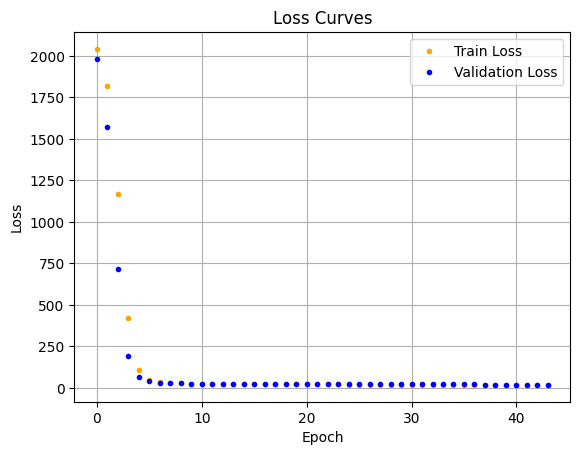


Epoch 44
---------


Train Loss: 17.3028 -|- Validation Loss: 19.6698 -|- Epoch Time: 38.8268 seconds


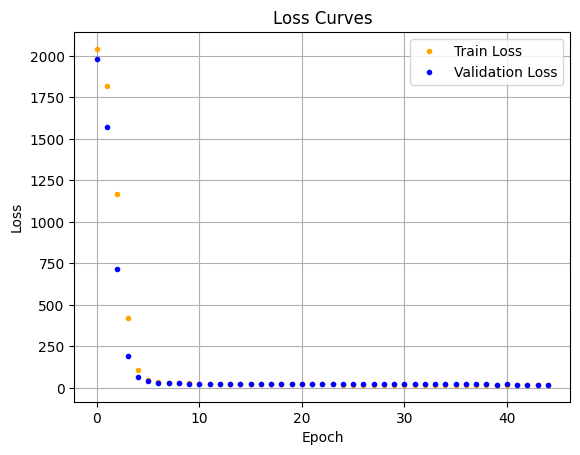


Epoch 45
---------


Train Loss: 17.2498 -|- Validation Loss: 19.4024 -|- Epoch Time: 39.1484 seconds


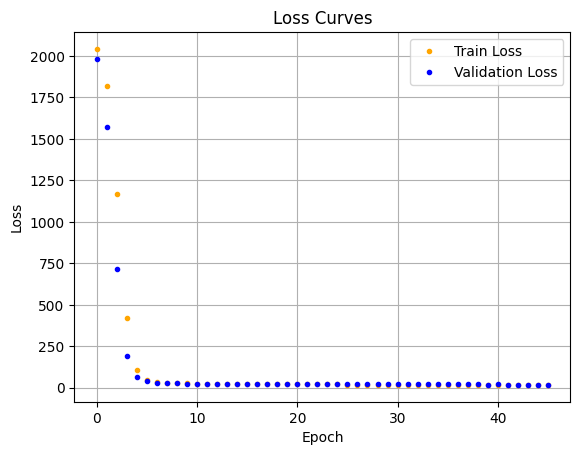


Epoch 46
---------


Train Loss: 17.1256 -|- Validation Loss: 19.6272 -|- Epoch Time: 39.1305 seconds


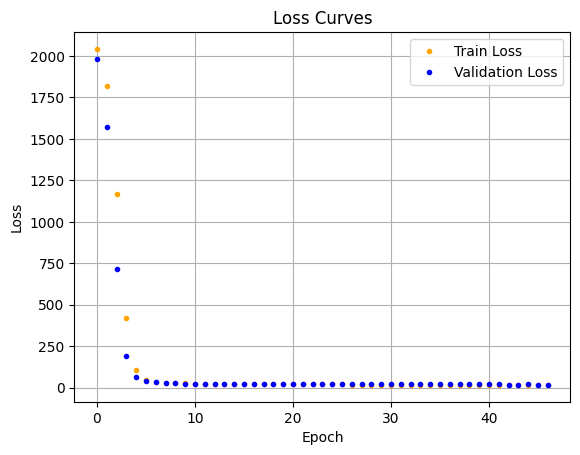


Epoch 47
---------


Train Loss: 17.0561 -|- Validation Loss: 19.5325 -|- Epoch Time: 39.2593 seconds


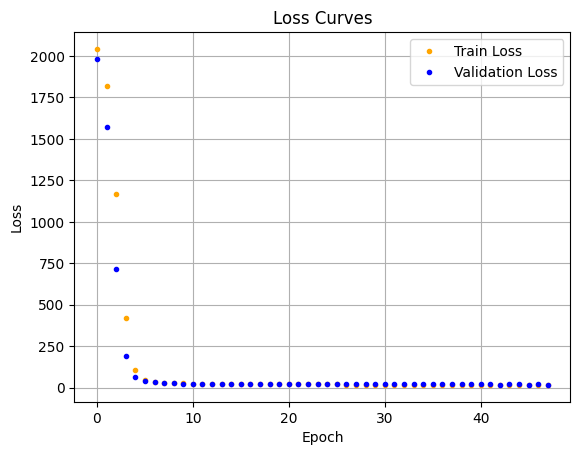


Epoch 48
---------


Train Loss: 16.8890 -|- Validation Loss: 19.5458 -|- Epoch Time: 39.4760 seconds


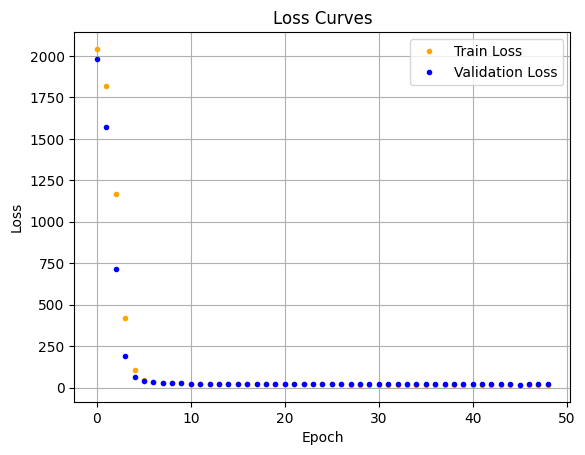


Epoch 49
---------


Train Loss: 16.8405 -|- Validation Loss: 19.5799 -|- Epoch Time: 39.4840 seconds


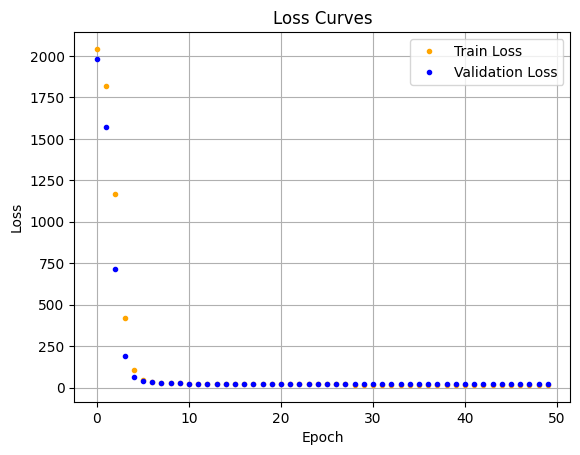


Epoch 50
---------


Train Loss: 16.7803 -|- Validation Loss: 19.3921 -|- Epoch Time: 38.9471 seconds


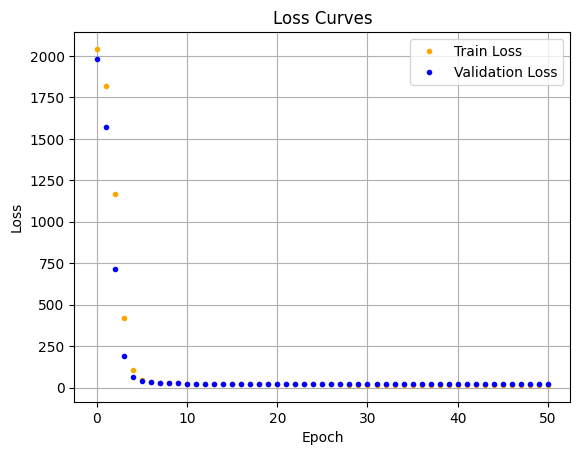


Epoch 51
---------


Train Loss: 16.6534 -|- Validation Loss: 19.2853 -|- Epoch Time: 38.7315 seconds


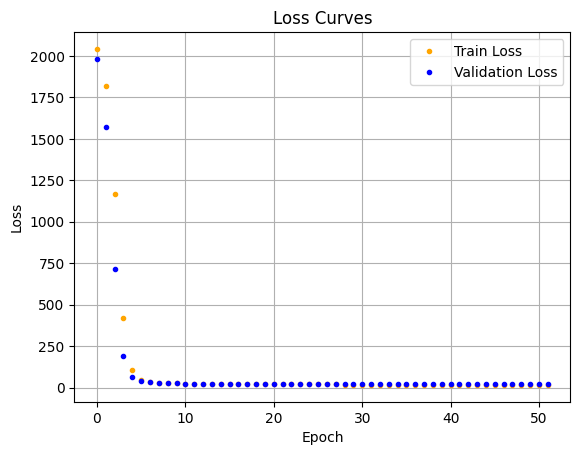


Epoch 52
---------


Train Loss: 16.6324 -|- Validation Loss: 19.2778 -|- Epoch Time: 39.2357 seconds


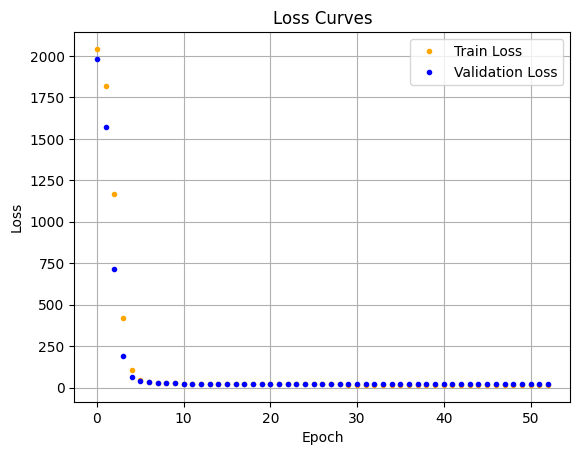


Epoch 53
---------


Train Loss: 16.4553 -|- Validation Loss: 19.2758 -|- Epoch Time: 39.1588 seconds


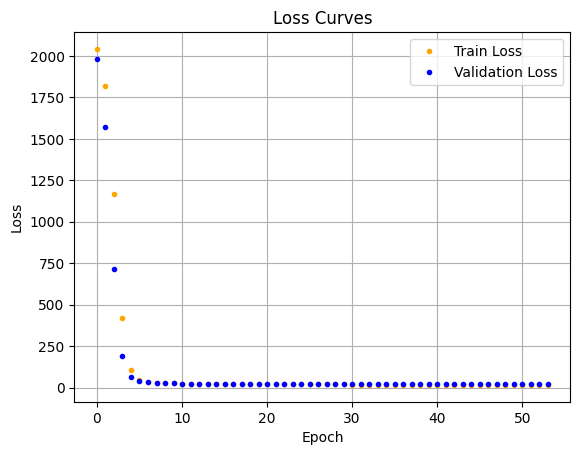


Epoch 54
---------


Train Loss: 16.4013 -|- Validation Loss: 19.2664 -|- Epoch Time: 39.1357 seconds


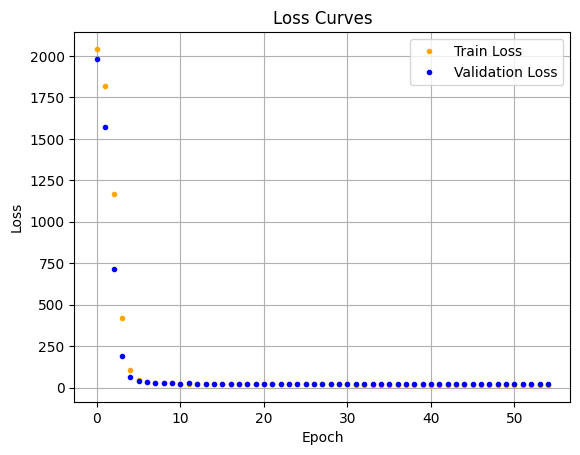


Epoch 55
---------


Train Loss: 16.3277 -|- Validation Loss: 18.9124 -|- Epoch Time: 39.1514 seconds


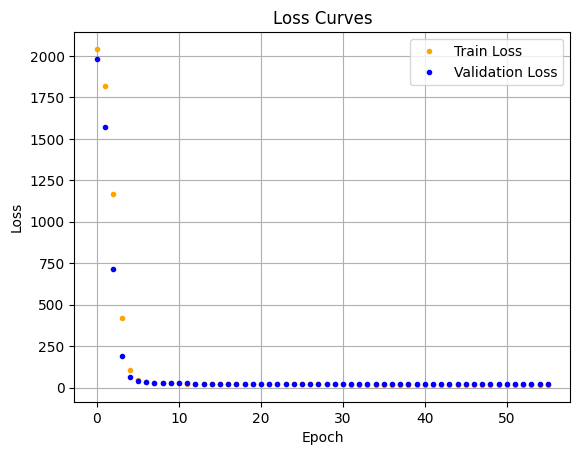


Epoch 56
---------


Train Loss: 16.2403 -|- Validation Loss: 19.2220 -|- Epoch Time: 39.1577 seconds


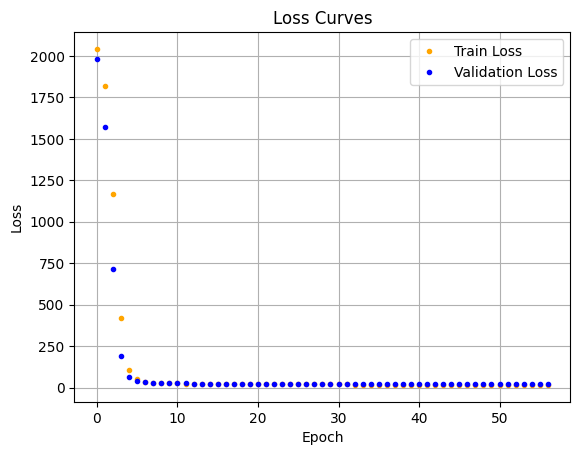


Epoch 57
---------


Train Loss: 16.1587 -|- Validation Loss: 19.6354 -|- Epoch Time: 39.1650 seconds


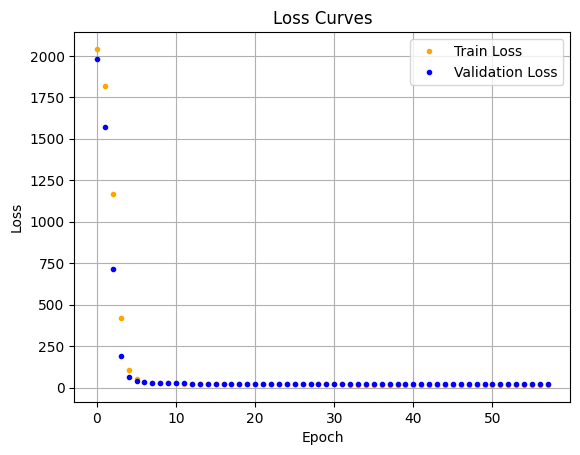


Epoch 58
---------


Train Loss: 16.0454 -|- Validation Loss: 19.2677 -|- Epoch Time: 39.0014 seconds


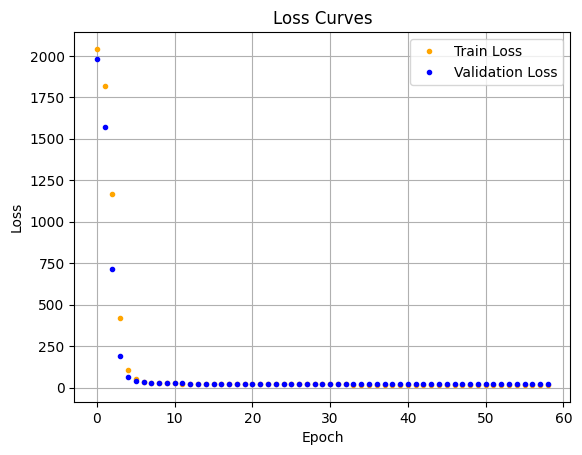


Epoch 59
---------


Train Loss: 15.9462 -|- Validation Loss: 18.9809 -|- Epoch Time: 39.0173 seconds


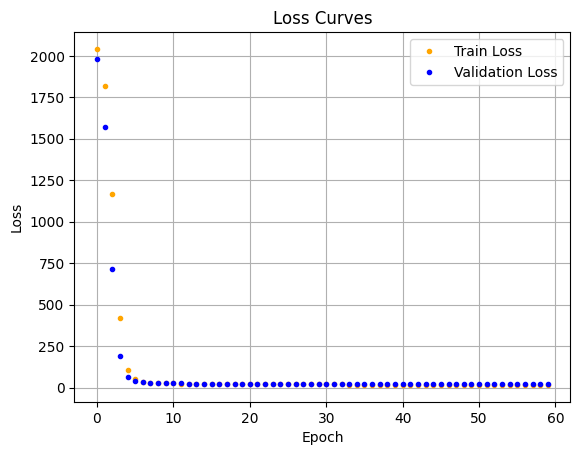


Epoch 60
---------


Train Loss: 15.9334 -|- Validation Loss: 18.8549 -|- Epoch Time: 39.1396 seconds


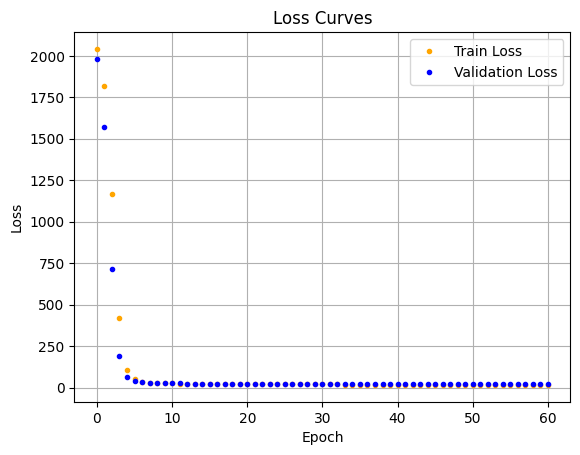


Epoch 61
---------


Train Loss: 15.8024 -|- Validation Loss: 19.4207 -|- Epoch Time: 39.1233 seconds


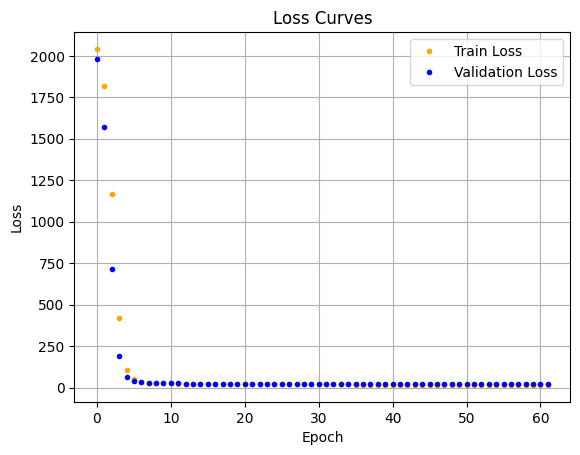


Epoch 62
---------


Train Loss: 15.6887 -|- Validation Loss: 19.0656 -|- Epoch Time: 39.0586 seconds


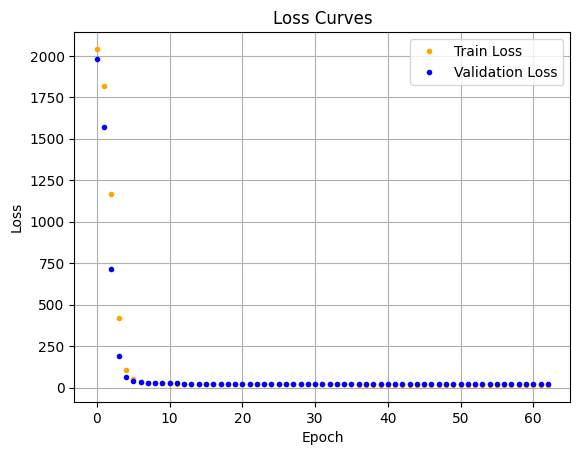


Epoch 63
---------


Train Loss: 15.6406 -|- Validation Loss: 18.7523 -|- Epoch Time: 39.1007 seconds


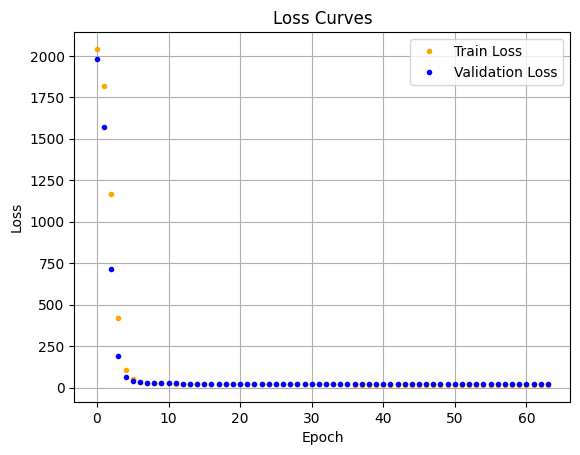


Epoch 64
---------


Train Loss: 15.4891 -|- Validation Loss: 18.9024 -|- Epoch Time: 39.2751 seconds


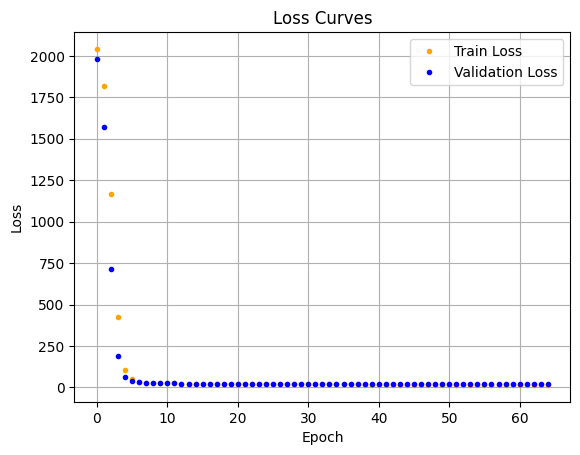


Epoch 65
---------


Train Loss: 15.4747 -|- Validation Loss: 18.6681 -|- Epoch Time: 39.2765 seconds


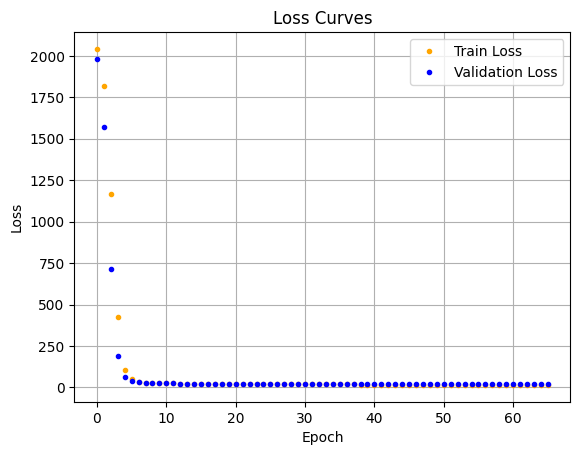


Epoch 66
---------


Train Loss: 15.3437 -|- Validation Loss: 18.9831 -|- Epoch Time: 39.2248 seconds


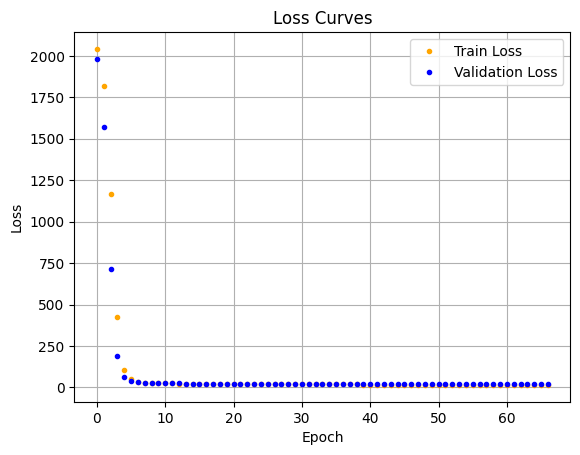


Epoch 67
---------


Train Loss: 15.2710 -|- Validation Loss: 18.8892 -|- Epoch Time: 39.2150 seconds


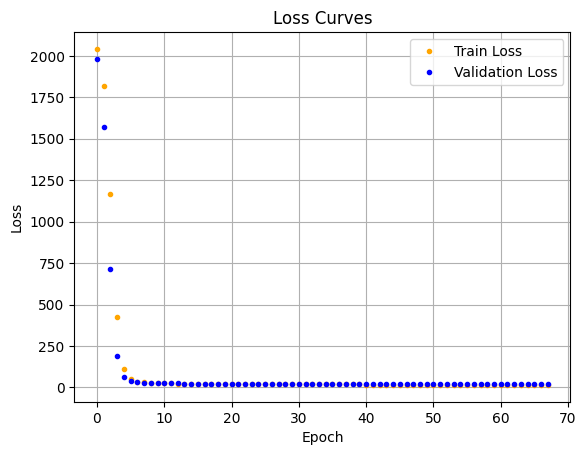


Epoch 68
---------


Train Loss: 15.2473 -|- Validation Loss: 19.0052 -|- Epoch Time: 39.2003 seconds


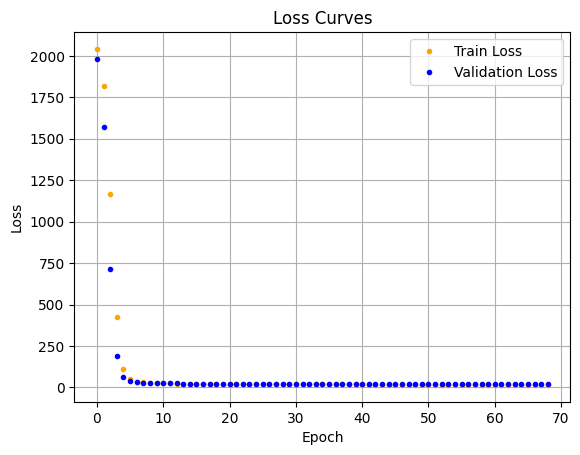


Epoch 69
---------


Train Loss: 15.1157 -|- Validation Loss: 18.9871 -|- Epoch Time: 39.1433 seconds


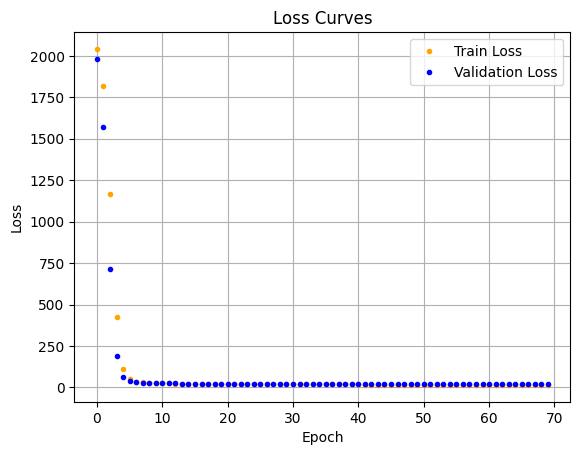


Epoch 70
---------


Train Loss: 15.0372 -|- Validation Loss: 18.5613 -|- Epoch Time: 39.1899 seconds


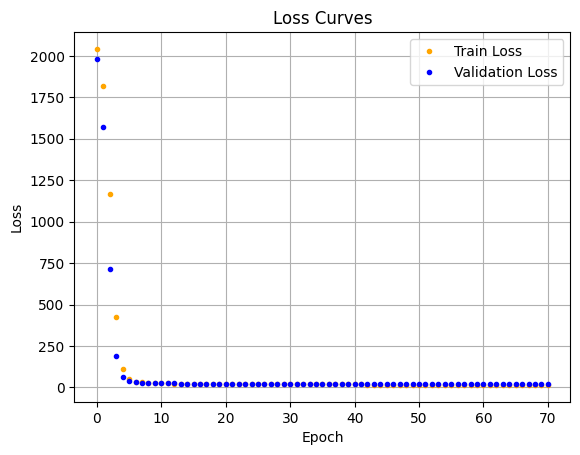


Epoch 71
---------


Train Loss: 15.0206 -|- Validation Loss: 18.8339 -|- Epoch Time: 39.1951 seconds


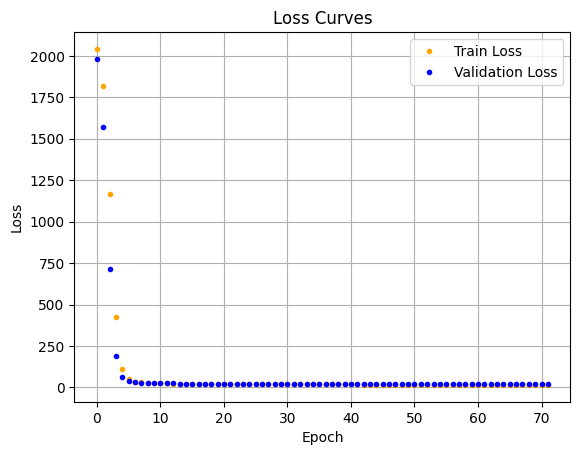


Epoch 72
---------


Train Loss: 14.9091 -|- Validation Loss: 19.0441 -|- Epoch Time: 39.1294 seconds


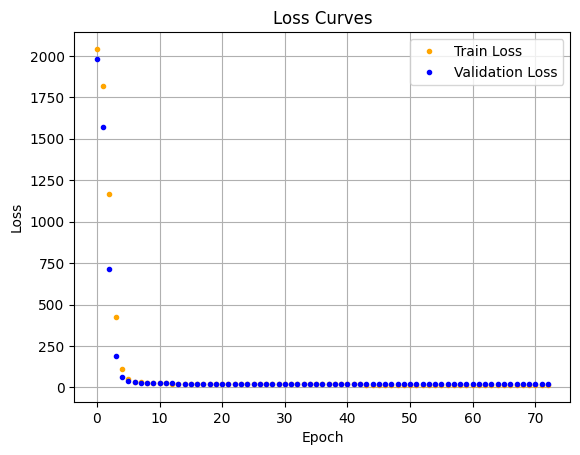


Epoch 73
---------


Train Loss: 14.7976 -|- Validation Loss: 18.6121 -|- Epoch Time: 39.1544 seconds


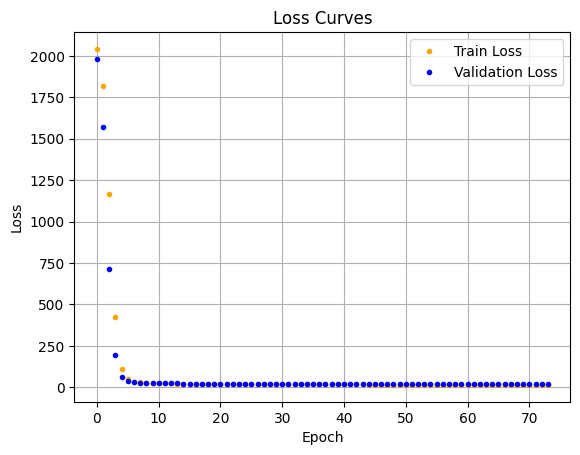


Epoch 74
---------


Train Loss: 14.7840 -|- Validation Loss: 18.6373 -|- Epoch Time: 39.1164 seconds


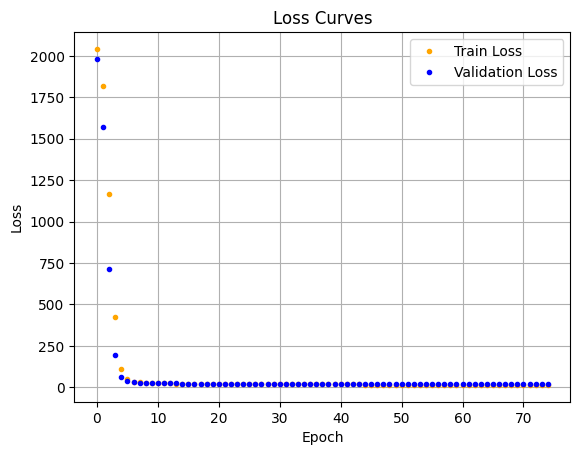


Epoch 75
---------


Train Loss: 14.6266 -|- Validation Loss: 18.5513 -|- Epoch Time: 39.1446 seconds


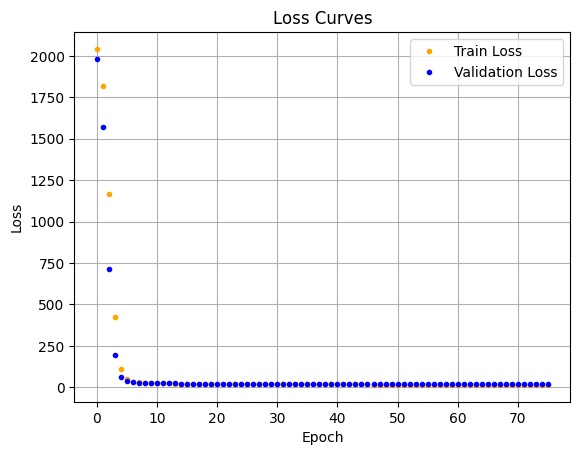


Epoch 76
---------


Train Loss: 14.5677 -|- Validation Loss: 18.5791 -|- Epoch Time: 39.1290 seconds


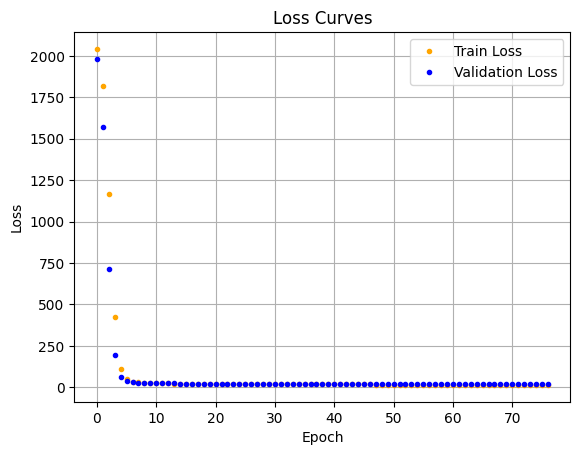


Epoch 77
---------


Train Loss: 14.5551 -|- Validation Loss: 18.4246 -|- Epoch Time: 39.1595 seconds


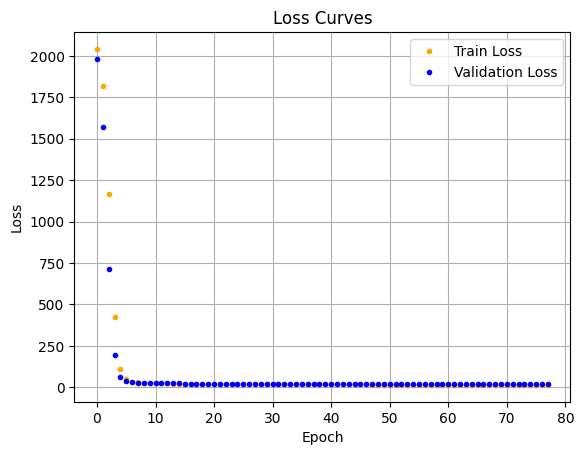


Epoch 78
---------


Train Loss: 14.4691 -|- Validation Loss: 19.2524 -|- Epoch Time: 39.0522 seconds


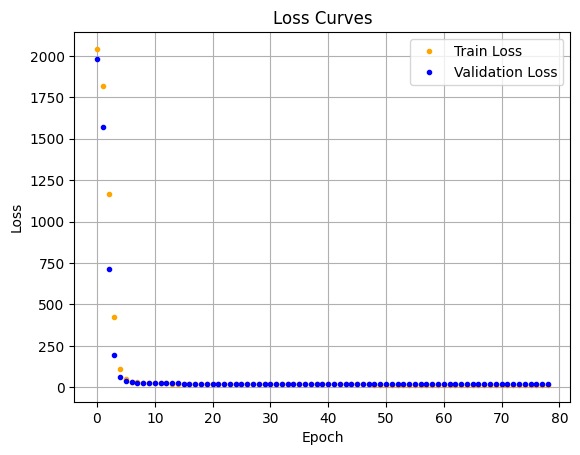


Epoch 79
---------


Train Loss: 14.3614 -|- Validation Loss: 18.4164 -|- Epoch Time: 38.8373 seconds


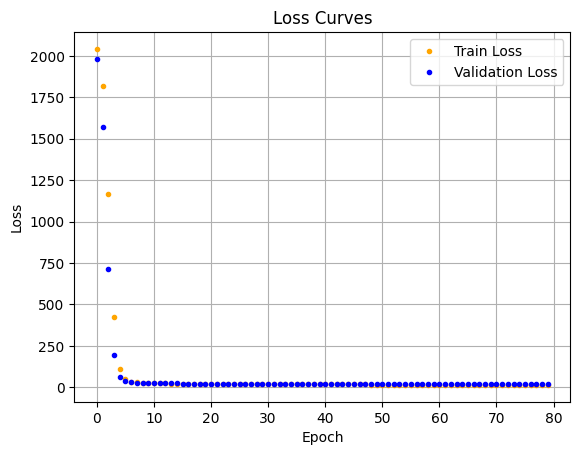


Epoch 80
---------


Train Loss: 14.2392 -|- Validation Loss: 18.3124 -|- Epoch Time: 38.8033 seconds


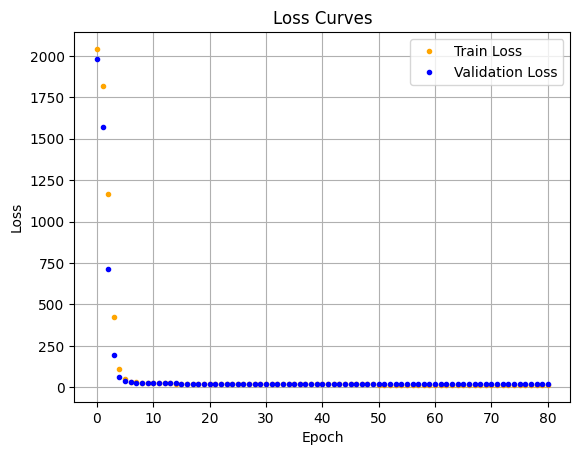


Epoch 81
---------


Train Loss: 14.2140 -|- Validation Loss: 18.6026 -|- Epoch Time: 38.8999 seconds


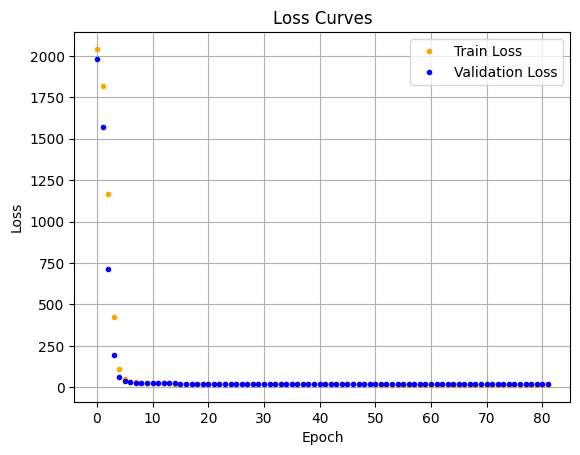


Epoch 82
---------


Train Loss: 14.1826 -|- Validation Loss: 18.5336 -|- Epoch Time: 38.9022 seconds


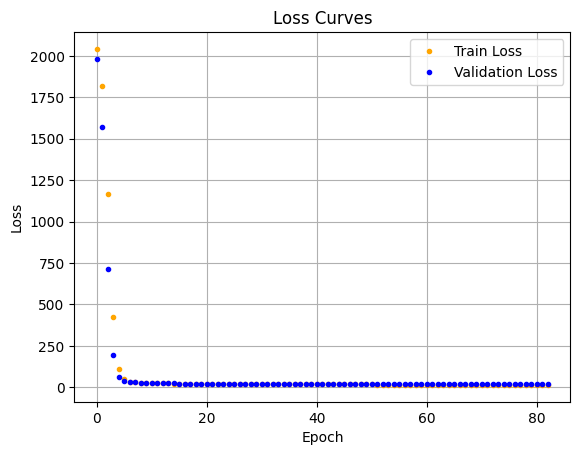


Epoch 83
---------


Train Loss: 14.0596 -|- Validation Loss: 18.5081 -|- Epoch Time: 38.8713 seconds


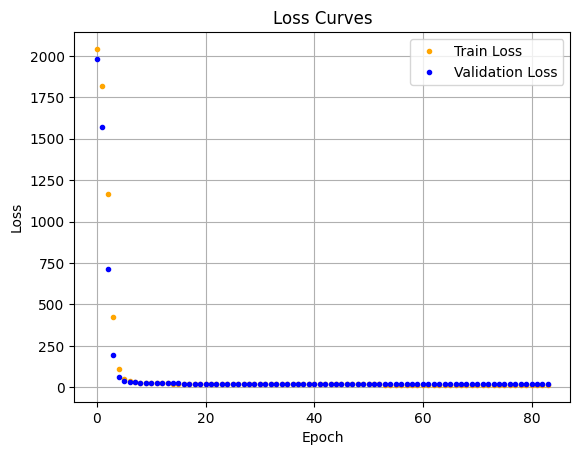


Epoch 84
---------


Train Loss: 14.0046 -|- Validation Loss: 18.4551 -|- Epoch Time: 38.8052 seconds


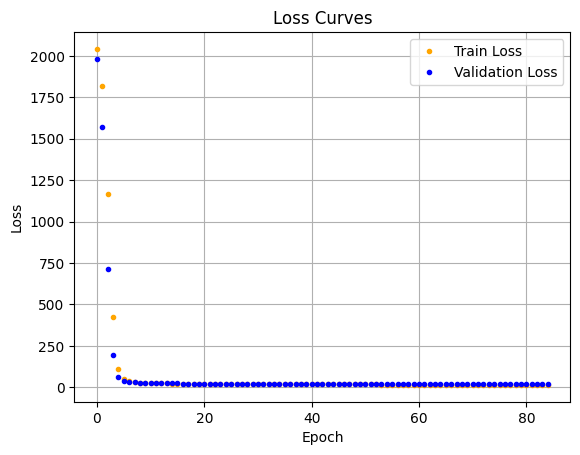


Epoch 85
---------


Train Loss: 13.9487 -|- Validation Loss: 18.4056 -|- Epoch Time: 38.6944 seconds


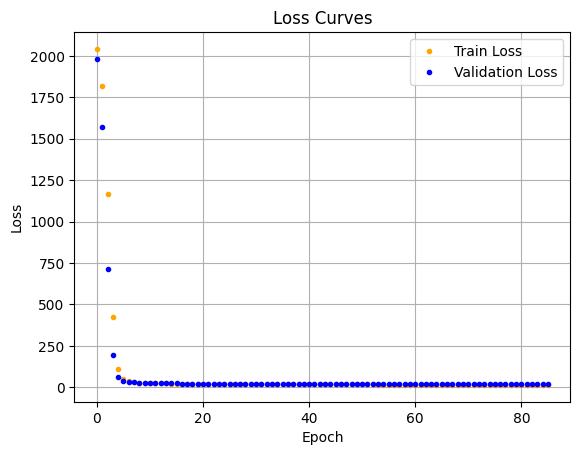


Epoch 86
---------


Train Loss: 13.8949 -|- Validation Loss: 18.3408 -|- Epoch Time: 38.6747 seconds


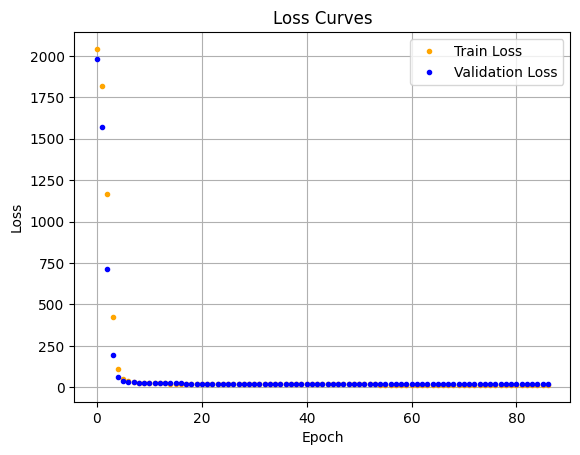


Epoch 87
---------


Train Loss: 13.7885 -|- Validation Loss: 18.2077 -|- Epoch Time: 38.7360 seconds


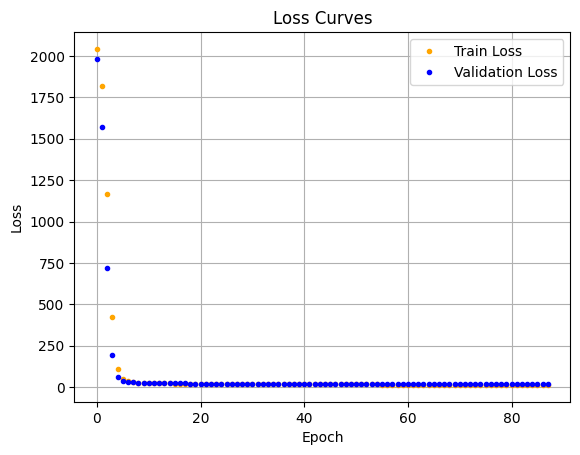


Epoch 88
---------


Train Loss: 13.7042 -|- Validation Loss: 18.2200 -|- Epoch Time: 38.7026 seconds


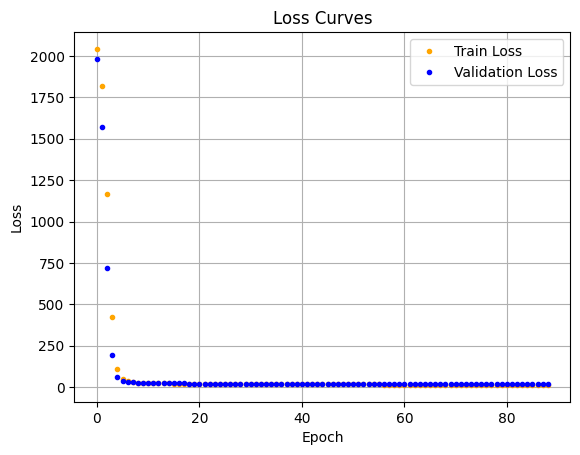


Epoch 89
---------


Train Loss: 13.6454 -|- Validation Loss: 18.3529 -|- Epoch Time: 38.7474 seconds


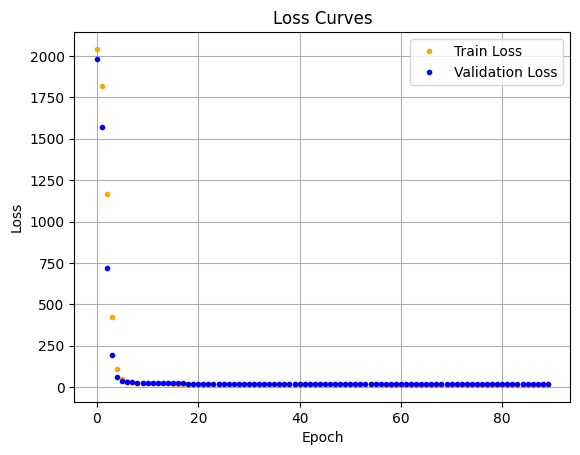


Epoch 90
---------


Train Loss: 13.5834 -|- Validation Loss: 18.4388 -|- Epoch Time: 38.8500 seconds


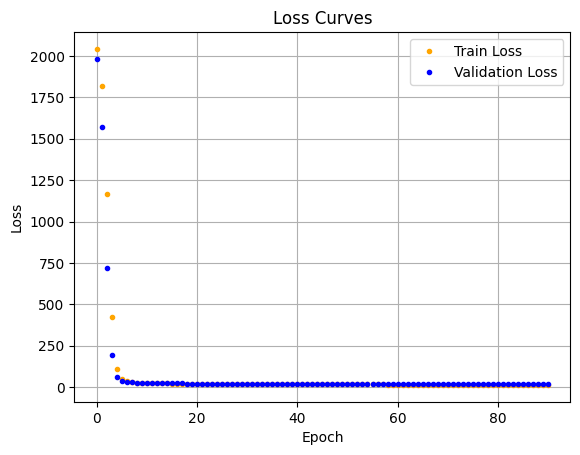


Epoch 91
---------


Train Loss: 13.4994 -|- Validation Loss: 18.1906 -|- Epoch Time: 38.8391 seconds


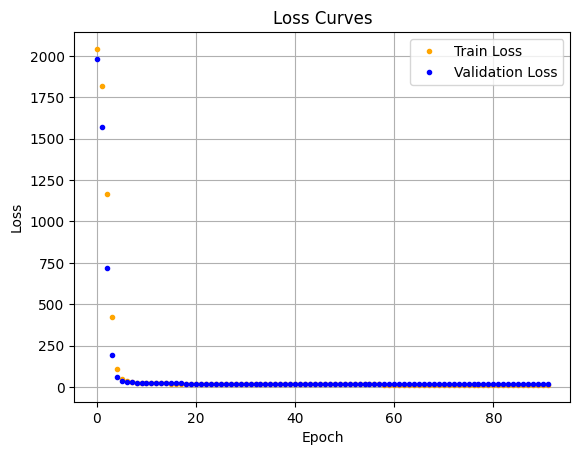


Epoch 92
---------


Train Loss: 13.4050 -|- Validation Loss: 18.1892 -|- Epoch Time: 38.8168 seconds


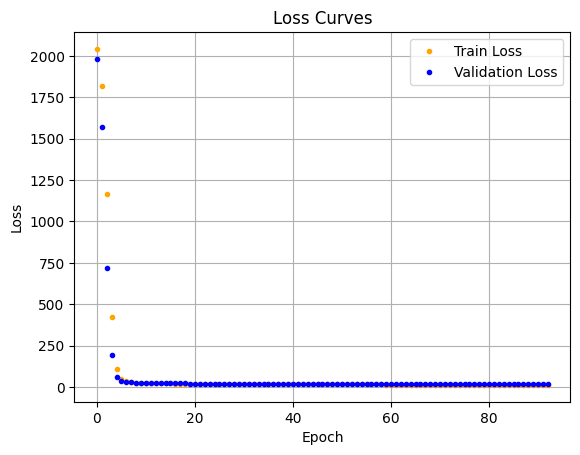


Epoch 93
---------


Train Loss: 13.3364 -|- Validation Loss: 18.3315 -|- Epoch Time: 38.8436 seconds


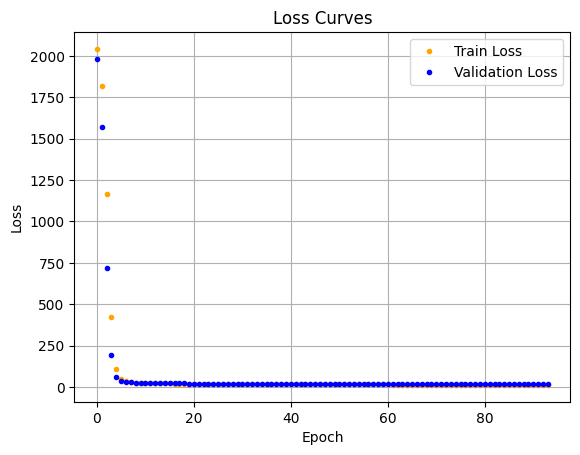


Epoch 94
---------


Train Loss: 13.3342 -|- Validation Loss: 18.1724 -|- Epoch Time: 38.7967 seconds


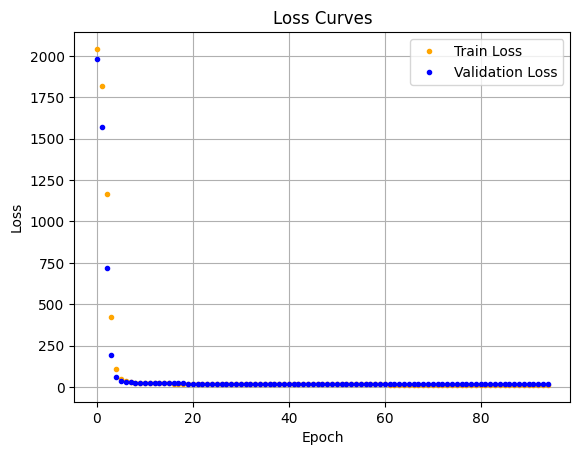


Epoch 95
---------


Train Loss: 13.2350 -|- Validation Loss: 17.9667 -|- Epoch Time: 38.7904 seconds


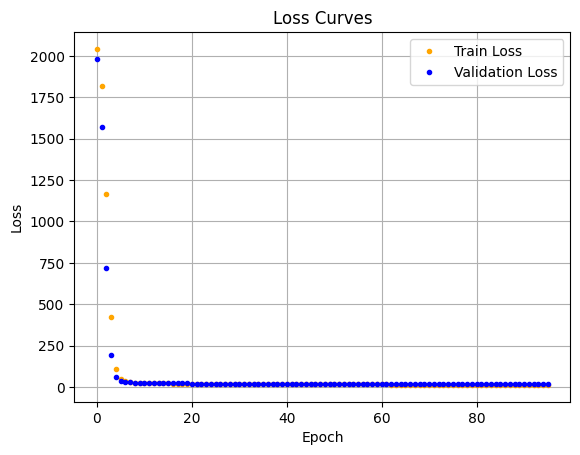


Epoch 96
---------


Train Loss: 13.1688 -|- Validation Loss: 18.3413 -|- Epoch Time: 38.8474 seconds


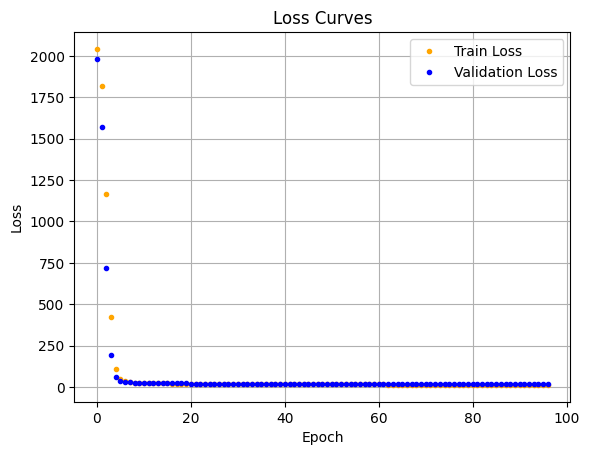


Epoch 97
---------


Train Loss: 13.0679 -|- Validation Loss: 17.9937 -|- Epoch Time: 38.8466 seconds


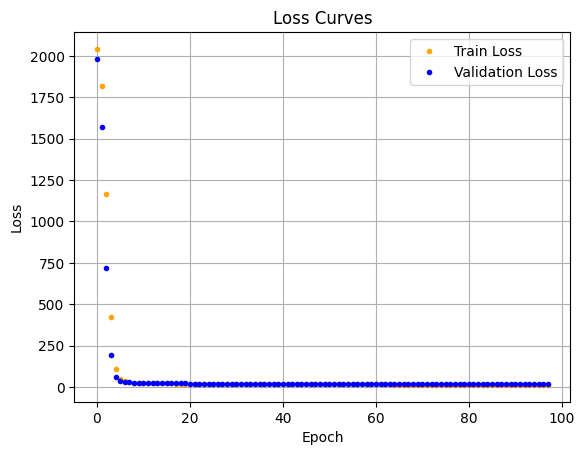


Epoch 98
---------


Train Loss: 13.0402 -|- Validation Loss: 18.1952 -|- Epoch Time: 38.8201 seconds


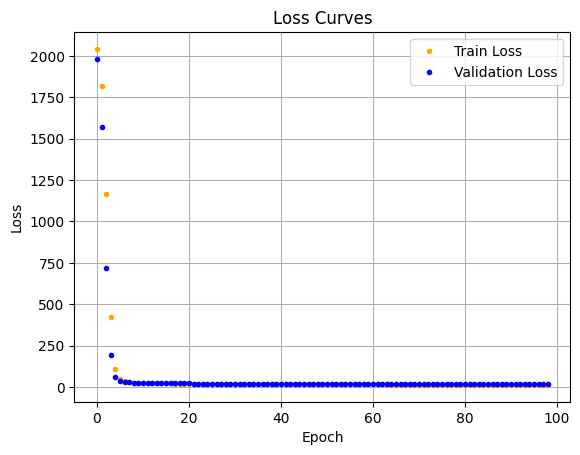


Epoch 99
---------


Train Loss: 12.9710 -|- Validation Loss: 18.2649 -|- Epoch Time: 38.8402 seconds


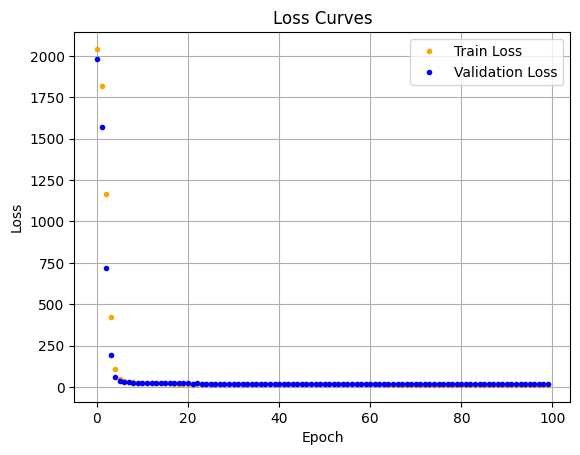

In [117]:
import numpy as np
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

model = model.to('cuda')

train_loss_list = np.array([])
val_loss_list = np.array([])

for ix_epoch in range(100):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, model, loss_function, optimizer, device='cuda')
    validation_loss = validate_model(val_loader, model, loss_function, device='cuda')
    end = time.time()
    epoch_time = end - start
    train_loss_list = np.append(train_loss_list, train_loss)
    val_loss_list = np.append(val_loss_list, validation_loss)
    print(f'Train Loss: {train_loss:0.4f} -|- Validation Loss: {validation_loss:0.4f} -|- Epoch Time: {epoch_time:0.4f} seconds')
    plt.plot(range(len(train_loss_list)),train_loss_list, '.', c='orange', label='Train Loss')
    plt.plot(range(len(train_loss_list)),val_loss_list, '.', c='blue', label='Validation Loss')
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.savefig(f'Animations/Model_1_Loss_Curves_{ix_epoch}.png')
    plt.show()
    print()

In [5]:
# Save the entire model (not recommended for production)
model = torch.load('Models/Model_1_Final.pth', weights_only=False)

R² Score: 0.9869


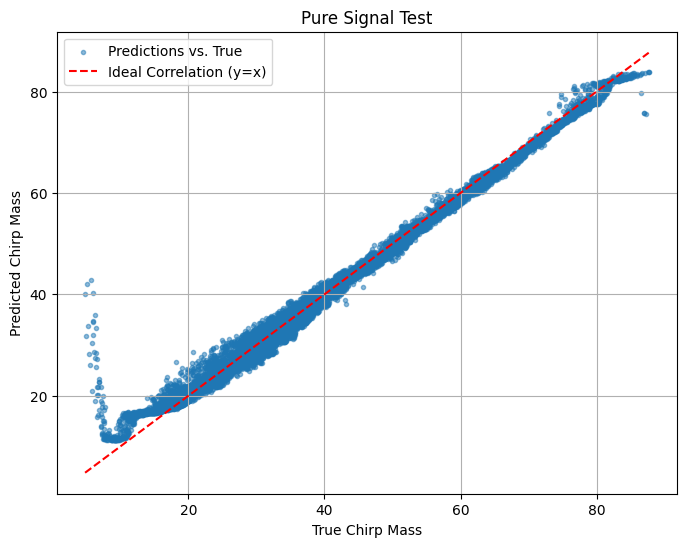

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Set model to evaluation mode
model.eval()

# Store results
predictions = []
true_labels = []

# Disable gradients for evaluation
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to('cuda'), y_test.to('cuda')

        # Get predictions
        outputs = model(X_test)

        # Store predictions and true labels
        predictions.append(outputs.cpu().numpy())
        true_labels.append(y_test.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Calculate and plot the R^2
r2 = r2_score(true_labels, predictions)
print(f"R² Score: {r2:.4f}")

# --- PLOTTING ---
plt.figure(figsize=(8, 6))
plt.scatter(true_labels, predictions, marker='.', alpha=0.5, label="Predictions vs. True")
plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'r--', label="Ideal Correlation (y=x)")
plt.xlabel("True Chirp Mass")
plt.ylabel("Predicted Chirp Mass")
plt.title("Pure Signal Test")
plt.legend()
plt.grid(True)
plt.savefig("(4)_Media/Model_1_Final_Performance_JustSignal.png")
plt.show()

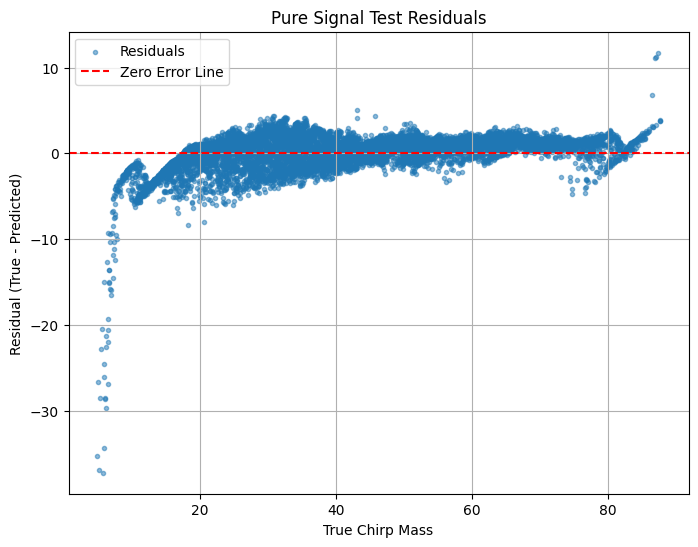

In [11]:
residuals = true_labels - predictions

plt.figure(figsize=(8, 6))
plt.scatter(true_labels, residuals, marker='.', alpha=0.5, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("True Chirp Mass")
plt.ylabel("Residual (True - Predicted)")
plt.title("Pure Signal Test Residuals")
plt.legend()
plt.grid(True)
plt.savefig('(4)_Media/Model_1_Final_Performance_Residual_JustSignal.png')
plt.show()

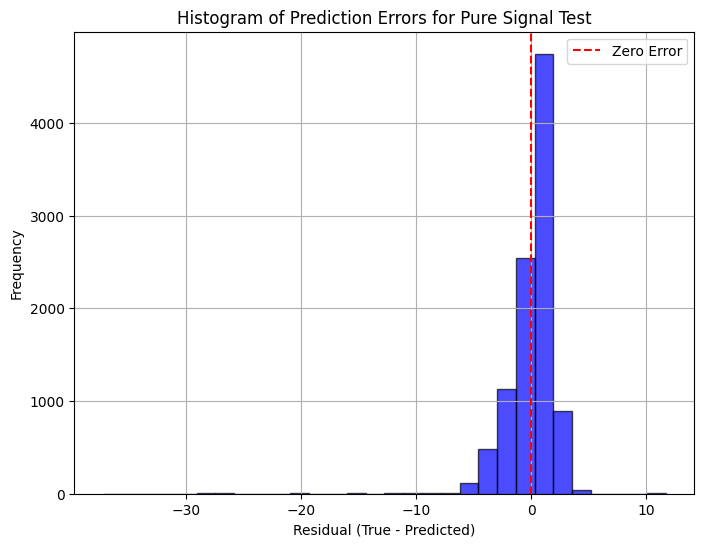

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label="Zero Error")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors for Pure Signal Test")
plt.legend()
plt.grid(True)
plt.savefig('(4)_Media/Model_1_Final_Performance_Residual_Histogram_JustSignal.png')
plt.show()

In [13]:
average = np.mean(residuals)
stdev = np.std(residuals)
average, stdev

(np.float32(0.099010594), np.float32(2.150475))